# 0.0. IMPORTS

In [1]:
import math
import inflection
import datetime
        
import numpy             as np
import pandas            as pd
import seaborn           as sns
import xgboost           as xgb
import matplotlib.pyplot as plt

from IPython.core.display  import HTML
from IPython.display       import Image
from scipy                 import stats as ss
from tabulate              import tabulate
from boruta                import BorutaPy

from sklearn.metrics       import mean_absolute_error, mean_absolute_percentage_error, mean_squared_error
from sklearn.ensemble      import RandomForestRegressor
from sklearn.linear_model  import LinearRegression, Lasso
from sklearn.preprocessing import RobustScaler, MinMaxScaler, LabelEncoder

## 0.1. Helper Functions

In [2]:
def jupyter_settings():
    %matplotlib inline
    %pylab inline
    
    plt.style.use( 'bmh' )
    plt.rcParams['figure.figsize'] = [25, 12]
    plt.rcParams['font.size'] = 24
    
    display( HTML( '<style>.container { width:100% !important; }</style>') )
    pd.options.display.max_columns = None
    pd.options.display.max_rows = None
    pd.set_option( 'display.expand_frame_repr', False )
    
    sns.set()
    sns.set_style('whitegrid')
    
def cramer_v(x,y):    
    cm = pd.crosstab(x, y).values                     # confusion matrix
    n = cm.sum()
    r, k = cm.shape
    
    chi2 = ss.chi2_contingency(cm)[0]                 # from pearson chi-squared test
    chi2_corr = max(0, chi2 - ((k-1)*(r-1) / (n-1)))
    
    k_corr = k - ((k-1)**2 / (n-1))
    r_corr = r - ((r-1)**2 / (n-1))
    
    return np.sqrt((chi2_corr/n) / min(k_corr-1, r_corr-1))          # cramer v

# when the course was recorded there was no mean_absolute_percentage_error function on sklearn
def mean_absolute_perc_error(y, yhat):
    return np.mean(np.abs((y - yhat) / y))

def ml_error(model_name, y, yhat):
    mae = mean_absolute_error(y, yhat)
    mape = mean_absolute_perc_error(y, yhat)
    rmse = np.sqrt(mean_squared_error(y, yhat))
    
    return pd.DataFrame({'Model Name': model_name,
                         'MAE': mae,
                         'MAPE': mape,
                         'RMSE': rmse}, index=[0])

def cross_val(x_training, kfold, model_name, model, verbose=False):

    mae_list = []
    mape_list = []
    rmse_list = []

    for k in reversed(range(1, kfold+1)):
        if verbose:
            print('\nKFold Number: {}'.format(k))
            
        # defining validation periods
        validation_date_start = x_training['date'].max() - datetime.timedelta(days=k*6*7)  # 6 weeks * 7 days
        validation_date_end = x_training['date'].max() - datetime.timedelta(days=(k-1)*6*7)  # 6 weeks * 7 days

        # filtering dataset
        training = x_training[x_training['date'] < validation_date_start]
        validation = x_training[(x_training['date'] >= validation_date_start) & (x_training['date'] <= validation_date_end)]

        # training and validation dataset
        # training
        xtraining = training.drop(['date', 'sales'], axis=1)
        ytraining = training['sales']

        # validation
        xvalidation = validation.drop(['date', 'sales'], axis=1)
        yvalidation = validation['sales']

        # model
        m = model.fit(xtraining, ytraining)

        # prediction
        yhat = m.predict(xvalidation)

        # performance
        m_result = ml_error(model_name, np.expm1(yvalidation), np.expm1(yhat))

        # store perfomance of each iteration
        mae_list.append(m_result['MAE'])
        mape_list.append(m_result['MAPE'])
        rmse_list.append(m_result['RMSE'])
    
    return pd.DataFrame({'Model Name': model_name,
                         'MAE CV': np.round(np.mean(mae_list), 2).astype(str) + ' +/- ' + np.round(np.std(mae_list), 2).astype(str),
                         'MAPE CV': np.round(np.mean(mape_list), 2).astype(str) + ' +/- ' + np.round(np.std(mape_list), 2).astype(str),     
                         'RMSE CV': np.round(np.mean(rmse_list), 2).astype(str) + ' +/- ' + np.round(np.std(rmse_list), 2).astype(str)}, index=[0])

In [3]:
jupyter_settings()

Populating the interactive namespace from numpy and matplotlib


## 0.2. Loading Data

In [4]:
df_sales_raw = pd.read_csv('data/train.csv', low_memory=False)
df_store_raw = pd.read_csv('data/store.csv', low_memory=False)

# merge
df_raw = pd.merge(df_sales_raw, df_store_raw, how='left', on='Store')

In [5]:
df_raw.sample()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
785793,504,6,2013-07-27,4907,753,1,0,0,1,c,c,820.0,NaN,NaN,0,NaN,NaN,NaN


# 1.0. STEP 01 - DATA DESCRIPTION

In [6]:
df1 = df_raw.copy()

## 1.1. Rename Columns

In [7]:
cols_old = ['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo',
       'StateHoliday', 'SchoolHoliday', 'StoreType', 'Assortment',
       'CompetitionDistance', 'CompetitionOpenSinceMonth',
       'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek',
       'Promo2SinceYear', 'PromoInterval']

snakecase = lambda x: inflection.underscore(x)

cols_new = list(map(snakecase, cols_old))

# rename
df1.columns = cols_new

## 1.2. Data Dimensions

In [8]:
print('Number of Rows: {}'.format(df1.shape[0]))
print('Number of Cols: {}'.format(df1.shape[1]))

Number of Rows: 1017209
Number of Cols: 18


## 1.3. Data Types

In [9]:
df1['date'] = pd.to_datetime(df1['date'])
df1.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month           float64
competition_open_since_year            float64
promo2                                   int64
promo2_since_week                      float64
promo2_since_year                      float64
promo_interval                          object
dtype: object

## 1.4. Check NA

** 3 principal methods to deal with NAs **
- Delete the lines with at least one NA value: easy to solve, however may discard a lot of valuable info in the dataset;
- Using the median, average or a machine learning method to fill the missing information;
- Trying to understand if the missing information was determined by a bussiness decision, and fill making a plausible assumption.

In [10]:
df1.isna().sum()

store                                0
day_of_week                          0
date                                 0
sales                                0
customers                            0
open                                 0
promo                                0
state_holiday                        0
school_holiday                       0
store_type                           0
assortment                           0
competition_distance              2642
competition_open_since_month    323348
competition_open_since_year     323348
promo2                               0
promo2_since_week               508031
promo2_since_year               508031
promo_interval                  508031
dtype: int64

## 1.5. Fillout NA

In [11]:
df1['competition_distance'].max()

75860.0

In [12]:
# competition_distance: distance in meters to the nearest competitor store
# solved based on assumption: if there is no distance info for the nearest competitor, maybe there is no competitor store
# in the first place. To fill the NA info, we can insert a much higher value than the maximum distance in the dataset.

df1['competition_distance'] = df1['competition_distance'].apply(lambda x: 200000.0 if math.isnan(x) else x)

# competition_open_since_month: gives the approximate month of the nearest competitor was opened
# based on assumption: apply current date if null
df1['competition_open_since_month'] = df1.apply(lambda x: x['date'].month if math.isnan(x['competition_open_since_month']) else x['competition_open_since_month'], axis=1)

# competition_open_since_year: gives the approximate year of the nearest competitor was opened
df1['competition_open_since_year'] = df1.apply(lambda x: x['date'].year if math.isnan(x['competition_open_since_year']) else x['competition_open_since_year'], axis=1)
                 
# promo2_since_week: describes the calendar week when the store started participating in Promo2
df1['promo2_since_week'] = df1.apply(lambda x: x['date'].week if math.isnan(x['promo2_since_week']) else x['promo2_since_week'], axis=1)

# promo2_since_year
df1['promo2_since_year'] = df1.apply(lambda x: x['date'].year if math.isnan(x['promo2_since_year']) else x['promo2_since_year'], axis=1)

# promo_interval: describes the consecutive intervals Promo2 is started, naming the months the promotion is started anew.
# e.g. 'feb, may, aug, nov' means each round starts in february, may, august, november of any given year for that store
# split the string in a list, and check if the any month coincides with the date to activate the promo2
month_map = {1: 'Jan', 2: 'Fev', 3: 'Mar', 4: 'Apr', 5: 'May', 6: 'Jun', 7: 'Jul', 8: 'Aug', 9: 'Sep', 10: 'Oct', 11: 'Nov', 12: 'Dec'}

df1['promo_interval'].fillna(0, inplace=True)

df1['month_map'] = df1['date'].dt.month.map(month_map)

df1['is_promo'] = df1[['promo_interval', 'month_map']].apply(lambda x: 0 if x['promo_interval'] == 0 else 1 if x['month_map'] in x['promo_interval'].split(',') else 0, axis=1)

In [13]:
df1.sample(5).T

,974333,631569,595968,416012,730117
store,609,150,229,903,578
day_of_week,5,4,1,2,7
date,2013-02-08 00:00:00,2013-12-12 00:00:00,2014-01-13 00:00:00,2014-06-24 00:00:00,2013-09-15 00:00:00
sales,4835,9189,5957,10595,4986
customers,533,830,568,726,556
open,1,1,1,1,1
promo,1,0,0,0,0
state_holiday,0,0,0,0,0
school_holiday,1,0,0,0,0
store_type,a,c,d,d,d


In [14]:
df1.isna().sum()

store                           0
day_of_week                     0
date                            0
sales                           0
customers                       0
open                            0
promo                           0
state_holiday                   0
school_holiday                  0
store_type                      0
assortment                      0
competition_distance            0
competition_open_since_month    0
competition_open_since_year     0
promo2                          0
promo2_since_week               0
promo2_since_year               0
promo_interval                  0
month_map                       0
is_promo                        0
dtype: int64

## 1.6. Change Types

In [15]:
df1.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month           float64
competition_open_since_year            float64
promo2                                   int64
promo2_since_week                      float64
promo2_since_year                      float64
promo_interval                          object
month_map                               object
is_promo                                 int64
dtype: object

In [16]:
df1['competition_open_since_month'] = df1['competition_open_since_month'].astype(int)
df1['competition_open_since_year'] = df1['competition_open_since_year'].astype(int)

df1['promo2_since_week'] = df1['promo2_since_week'].astype(int)
df1['promo2_since_year'] = df1['promo2_since_year'].astype(int)

In [17]:
df1.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month             int32
competition_open_since_year              int32
promo2                                   int64
promo2_since_week                        int32
promo2_since_year                        int32
promo_interval                          object
month_map                               object
is_promo                                 int64
dtype: object

## 1.7. Descriptive Statistics

In [18]:
num_attributes = df1.select_dtypes(include=['int64', 'int32', 'float64'])

cat_attributes = df1.select_dtypes(exclude=['int64', 'int32', 'float64', 'datetime64[ns]'])

### 1.7.1. Numerical Attributes

In [19]:
# Central tendency: mean, median
ct1 = pd.DataFrame(num_attributes.apply(np.mean)).T
ct2 = pd.DataFrame(num_attributes.apply(np.median)).T

# Dispersion: std, min, max, range, skew, kurtosis
d1 = pd.DataFrame(num_attributes.apply(np.std)).T
d2 = pd.DataFrame(num_attributes.apply(min)).T
d3 = pd.DataFrame(num_attributes.apply(max)).T
d4 = pd.DataFrame(num_attributes.apply(lambda x: x.max() - x.min())).T
d5 = pd.DataFrame(num_attributes.apply(lambda x: x.skew())).T
d6 = pd.DataFrame(num_attributes.apply(lambda x: x.kurtosis())).T

# concatenate results
m = pd.concat([d2, d3, d4, ct1, ct2, d1, d5, d6]).T.reset_index()
m.columns = ['attributes','min', 'max', 'range', 'avg', 'median', 'std', 'skew', 'kurtosis']

<AxesSubplot:xlabel='sales', ylabel='Count'>

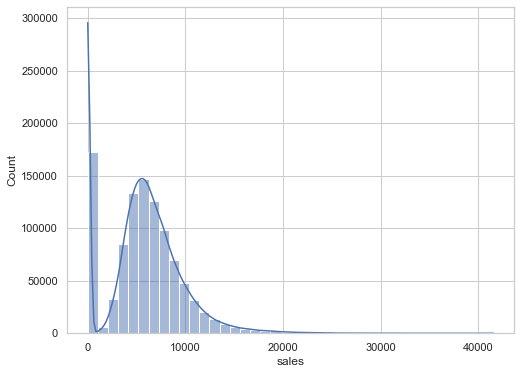

In [20]:
# sales distribution ----------> close to a normal: skew close to 0 and kurtosis close to 1
plt.figure(figsize=(8,6))
sns.histplot(df1['sales'], bins=40, kde=True)

<AxesSubplot:xlabel='competition_distance', ylabel='Count'>

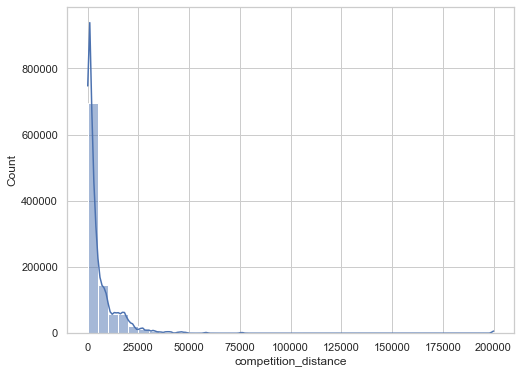

In [21]:
# sales distribution ----------> close to a poisson : high kurtosis and skew
plt.figure(figsize=(8,6))
sns.histplot(df1['competition_distance'], bins=40, kde=True)

### 1.7.2 Categorical Attributes

In [22]:
cat_attributes.apply(lambda x: x.unique().shape[0])

state_holiday      4
store_type         4
assortment         3
promo_interval     4
month_map         12
dtype: int64

<AxesSubplot:xlabel='assortment', ylabel='sales'>

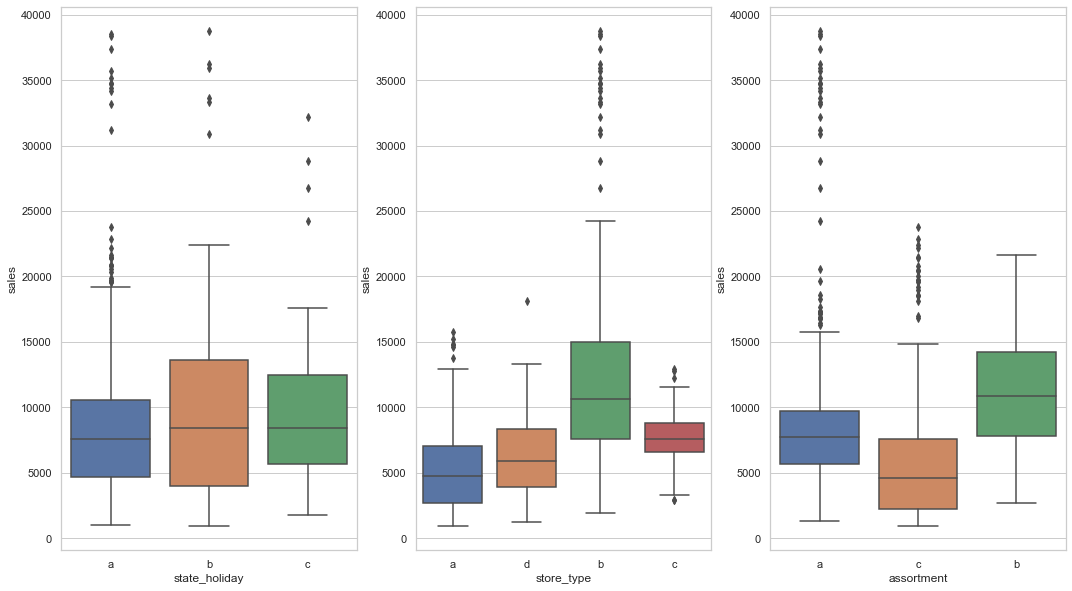

In [23]:
aux1 = df1[(df1['state_holiday'] != '0') & (df1['sales'] > 0)]
plt.figure(figsize=(18,10))
plt.subplot(1,3,1)
sns.boxplot(x='state_holiday', y='sales', data=aux1)

plt.subplot(1,3,2)
sns.boxplot(x='store_type', y='sales', data=aux1)

plt.subplot(1,3,3)
sns.boxplot(x='assortment', y='sales', data=aux1)

# 2.0. STEP 02 - FEATURE ENGINEERING

In [24]:
df2 = df1.copy()

## 2.1. Hypothesis Mind Map

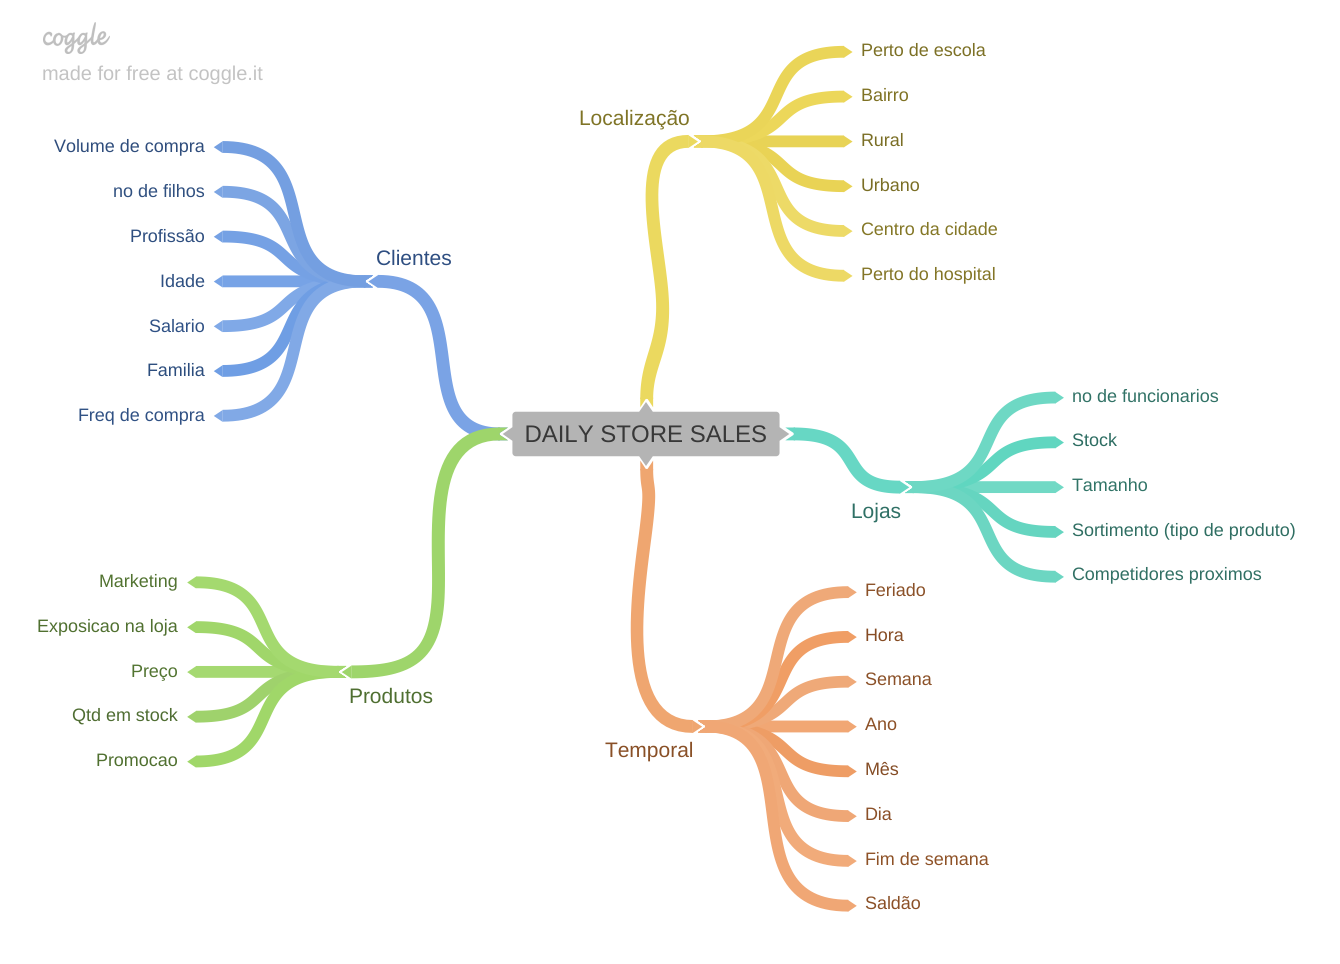

In [25]:
Image('img/MindMapHypothesis.png')

## 2.2. Hypothesis determination

### 2.2.1 Store related hypothesis

**1.** Stores with a higher number of employees should sell more.

**2.** Stores with a higher stock should sell more.

**3.** Bigger stores should sell more.

**4.** Stores with higher assortment should sell more.

**5.** Stores with closer competitors should sell less.

**6.** Stores with competitors for a longer period of time should sell more.

### 2.2.2 Product related hypothesis

**1.** Stores with higher marketing investment should sell more.

**2.** Stores with more products exposed in the showcase should sell more.

**3.** Stores with lower prices should sell more.

**4.** Stores with better promotions (bigger discounts) should sell more.

**5.** Stores with active promotions for a longer time should sell more.

**6.** Stores with more promotion days should sell more.

**7.** Stores with more consecutive promotions should sell more.

### 2.2.3 Time related hypothesis

**1.** Stores open during Christmas should sell more.

**2.** Stores should sell more along the years.

**3.** Stores should sell more in the second semester of the year.

**4.** Stores should sell more after the 10th day of each month.

**5.** Stores should sell less during weekends.

**6.** Stores should sell less during schoold holidays.

## 2.3. Final Hypothesis List

**1.** Stores with higher assortment should sell more.

**2.** Stores with closer competitors should sell less.

**3.** Stores with competitors for a longer period of time should sell more.

**4.** Stores with active promotions for a longer time should sell more.

**5.** Stores with more promotion days should sell more.

**6.** Stores with more consecutive promotions should sell more.

**7.** Stores open during Christmas should sell more.

**8.** Stores should sell more along the years.

**9.** Stores should sell more in the second semester of the year.

**10.** Stores should sell more after the 10th day of each month.

**11.** Stores should sell less during weekends.

**12.** Stores should sell less during schoold holidays.

## 2.4. Feature Engineering

In [26]:
# year
df2['year'] = df2['date'].dt.year
# month
df2['month'] = df2['date'].dt.month
# day
df2['day'] = df2['date'].dt.day
# week of year
df2['week_of_year'] = df2['date'].dt.isocalendar().week
# year week
df2['year_week'] = df2['date'].dt.strftime('%Y-%W')

# competition since
df2['competition_since'] = df2.apply(lambda x: datetime.datetime(year=x['competition_open_since_year'], month=x['competition_open_since_month'], day=1), axis=1)

df2['competition_time_month'] = ((df2['date'] - df2['competition_since'])/30).apply(lambda x: x.days).astype(int)     # how long there is a competitor nearby in months


# promo since
df2['promo_since'] = df2['promo2_since_year'].astype(str) + '-' + df2['promo2_since_week'].astype(str)

df2['promo_since'] = df2['promo_since'].apply(lambda x: datetime.datetime.strptime(x + '-1', '%Y-%W-%w') - datetime.timedelta(days=7))

df2['promo_time_week'] = ((df2['date'] - df2['promo_since'])/7).apply(lambda x: x.days).astype(int)      # how long a promotion is active in weeks


# assortment: a - basic, b - extra, c - extended
df2['assortment'] = df2['assortment'].apply(lambda x: 'basic' if x == 'a' else 'extra' if x == 'b' else 'extended')

# state holiday: a = public holiday, b = Easter holiday, c = Christmas, 0 = None
df2['state_holiday'] = df2['state_holiday'].apply(lambda x: 'public_holiday' if x == 'a'
                                                 else 'easter_holiday' if x == 'b'
                                                 else 'christmas' if x == 'c'
                                                 else 'regular_day')

In [27]:
df2.head().T

,0,1,2,3,4
store,1,2,3,4,5
day_of_week,5,5,5,5,5
date,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00
sales,5263,6064,8314,13995,4822
customers,555,625,821,1498,559
open,1,1,1,1,1
promo,1,1,1,1,1
state_holiday,regular_day,regular_day,regular_day,regular_day,regular_day
school_holiday,1,1,1,1,1
store_type,c,a,a,c,a


# 3.0. STEP 03 - DATA FILTERING

In [28]:
df3 = df2.copy()

In [29]:
df3.head()

,store,day_of_week,date,sales,customers,open,promo,state_holiday,school_holiday,store_type,assortment,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,promo_interval,month_map,is_promo,year,month,day,week_of_year,year_week,competition_since,competition_time_month,promo_since,promo_time_week
0,1,5,2015-07-31,5263,555,1,1,regular_day,1,c,basic,1270.0,9,2008,0,31,2015,0,Jul,0,2015,7,31,31,2015-30,2008-09-01,84,2015-07-27,0
1,2,5,2015-07-31,6064,625,1,1,regular_day,1,a,basic,570.0,11,2007,1,13,2010,"Jan,Apr,Jul,Oct",Jul,1,2015,7,31,31,2015-30,2007-11-01,94,2010-03-22,279
2,3,5,2015-07-31,8314,821,1,1,regular_day,1,a,basic,14130.0,12,2006,1,14,2011,"Jan,Apr,Jul,Oct",Jul,1,2015,7,31,31,2015-30,2006-12-01,105,2011-03-28,226
3,4,5,2015-07-31,13995,1498,1,1,regular_day,1,c,extended,620.0,9,2009,0,31,2015,0,Jul,0,2015,7,31,31,2015-30,2009-09-01,71,2015-07-27,0
4,5,5,2015-07-31,4822,559,1,1,regular_day,1,a,basic,29910.0,4,2015,0,31,2015,0,Jul,0,2015,7,31,31,2015-30,2015-04-01,4,2015-07-27,0


## 3.1. Row Filtering

Note: It is not possible to predict the sales from stores which are not open and have a volume of sales equal to 0.

In [30]:
df3 = df3[(df3['open'] != 0) & (df3['sales'] > 0)]

## 3.2. Column Filtering

Note: The number of customers is not avaible in six week ahead, which means we can not predict the volume of sales using this value.
The dataframe was filtered to consider only opened stores, which means this column will not influence our model.
The auxiliary columns promo_interval and month_map will also be removed.

In [31]:
cols_drop = ['customers', 'open', 'promo_interval', 'month_map']

df3 = df3.drop(cols_drop, axis=1)

# 4.0. STEP 04 - EXPLORATORY DATA ANALYSIS

In [32]:
df4 = df3.copy()

## 4.1. Univariate Analysis

### 4.1.1. Response Variable

<AxesSubplot:xlabel='sales', ylabel='Count'>

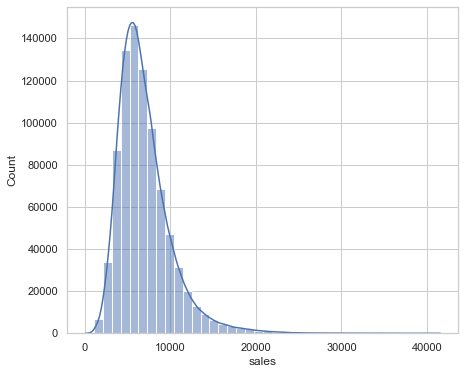

In [33]:
plt.figure(figsize=(7,6))
sns.histplot(df4['sales'], bins=40, kde=True)

### 4.1.2. Numerical Variables

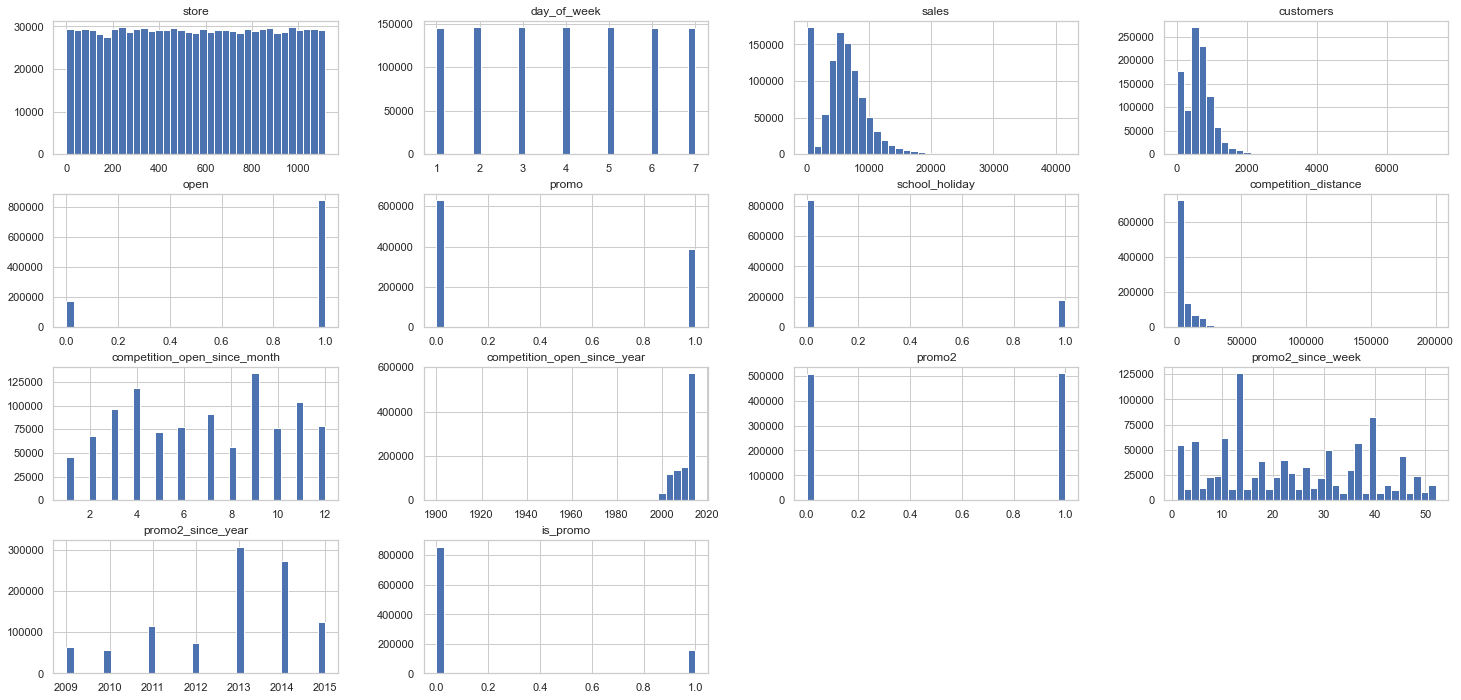

In [34]:
num_attributes.hist(bins=35);

### 4.1.3. Categorical Variables

In [35]:
df4['assortment'].drop_duplicates()

0         basic
3      extended
258       extra
Name: assortment, dtype: object

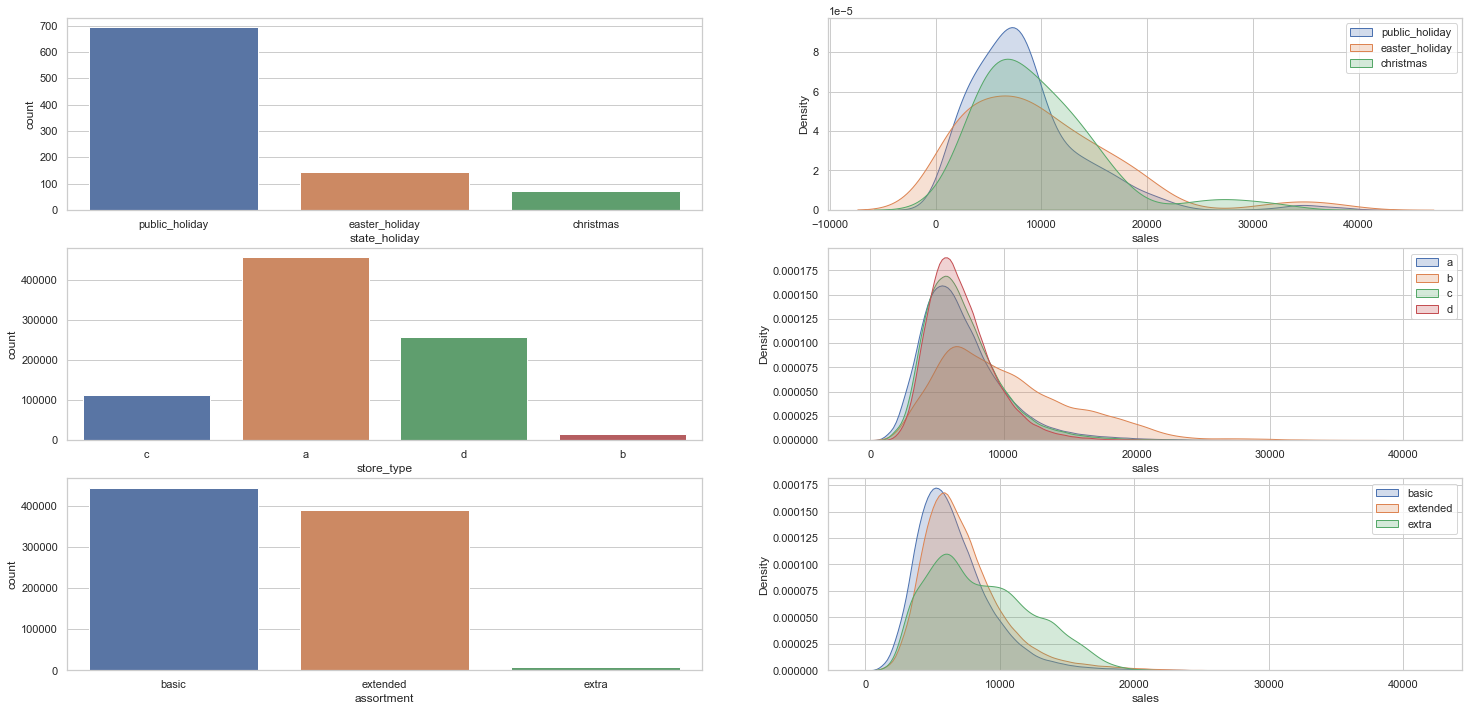

In [36]:
# state holiday
a = df4[df4['state_holiday'] != 'regular_day']

plt.subplot(3,2,1)
sns.countplot(x='state_holiday', data=a)

plt.subplot(3,2,2)
# sns.kdeplot(x='sales', data=df4[df4['state_holiday'] != 'regular_day'], hue='state_holiday', shade=True)      # this density is refering to the dataframe df4[df4['state_holiday'] != 'regular_day']

# this approach consideres a different density function for each dataframe df4[df4['state_holiday'] == ... ]
sns.kdeplot(df4[df4['state_holiday'] == 'public_holiday']['sales'], label='public_holiday', shade=True)
sns.kdeplot(df4[df4['state_holiday'] == 'easter_holiday']['sales'], label='easter_holiday', shade=True)
sns.kdeplot(df4[df4['state_holiday'] == 'christmas']['sales'], label='christmas', shade=True)
plt.legend()

# store type
plt.subplot(3,2,3)
sns.countplot(x='store_type', data=df4)

plt.subplot(3,2,4)
sns.kdeplot(df4[df4['store_type'] == 'a']['sales'], label='a', shade=True)
sns.kdeplot(df4[df4['store_type'] == 'b']['sales'], label='b', shade=True)
sns.kdeplot(df4[df4['store_type'] == 'c']['sales'], label='c', shade=True)
sns.kdeplot(df4[df4['store_type'] == 'd']['sales'], label='d', shade=True)
plt.legend()

# assortment
plt.subplot(3,2,5)
sns.countplot(x='assortment', data=df4)

plt.subplot(3,2,6)
sns.kdeplot(df4[df4['assortment'] == 'basic']['sales'], label='basic', shade=True)
sns.kdeplot(df4[df4['assortment'] == 'extended']['sales'], label='extended', shade=True)
sns.kdeplot(df4[df4['assortment'] == 'extra']['sales'], label='extra', shade=True)
plt.legend()

## 4.2. Bivariate Analysis

### **H1.** Stores with higher assortment should sell more.

**False** Stores with SMALLER assortment sell LESS  -------> Can generate an Insight

<AxesSubplot:xlabel='year_week'>

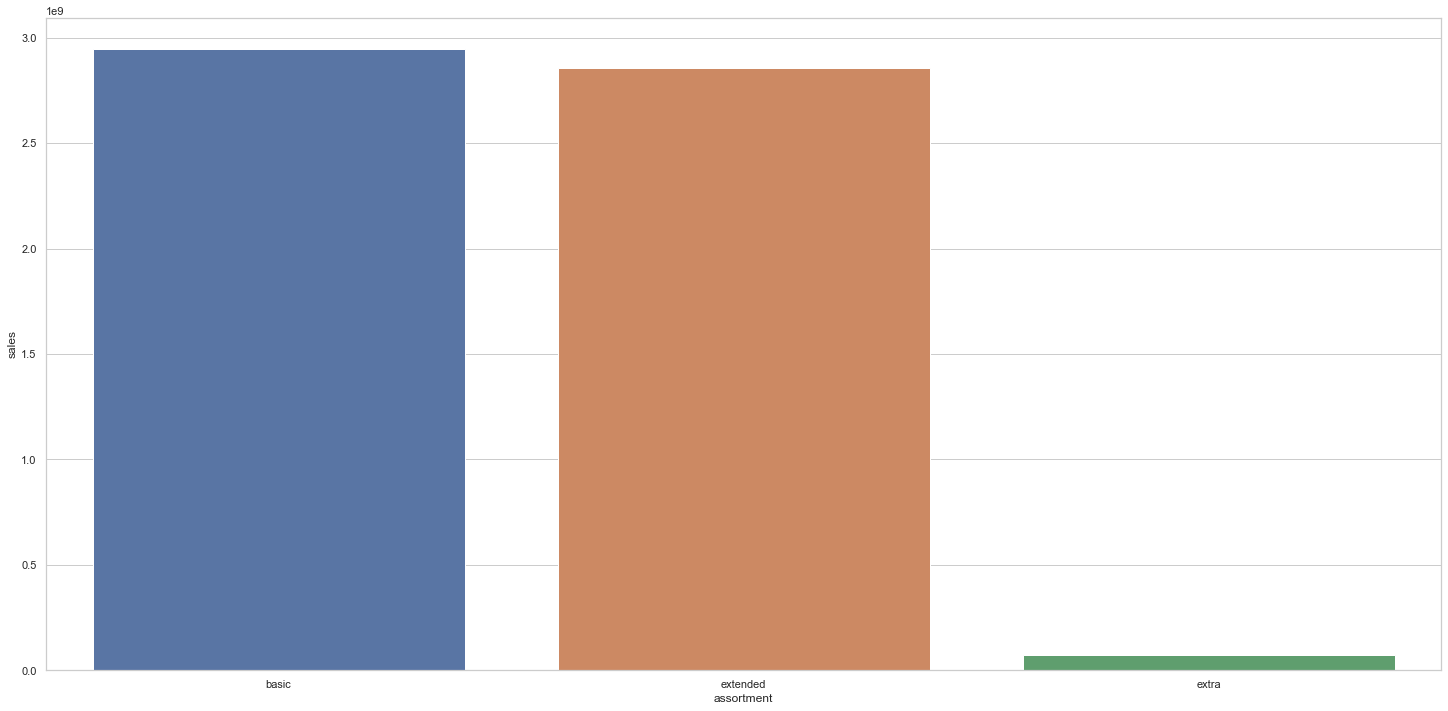

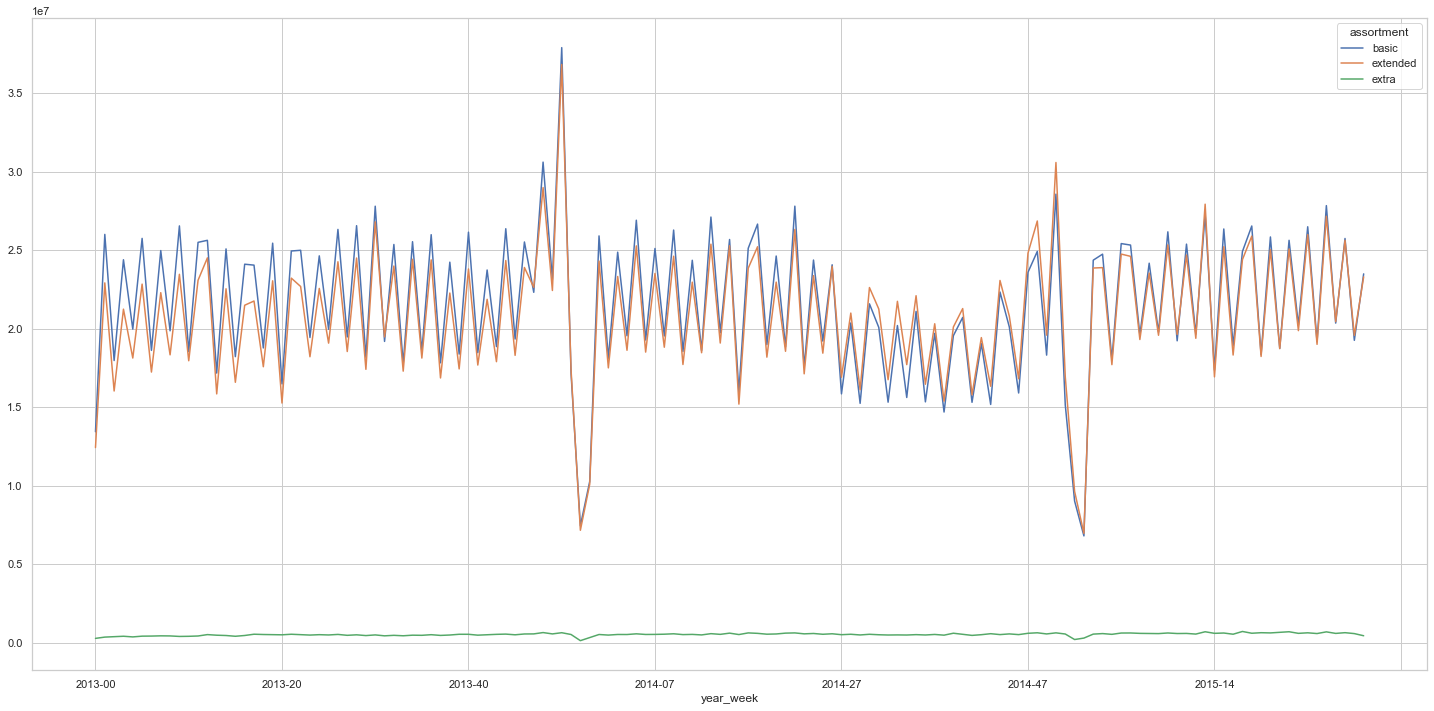

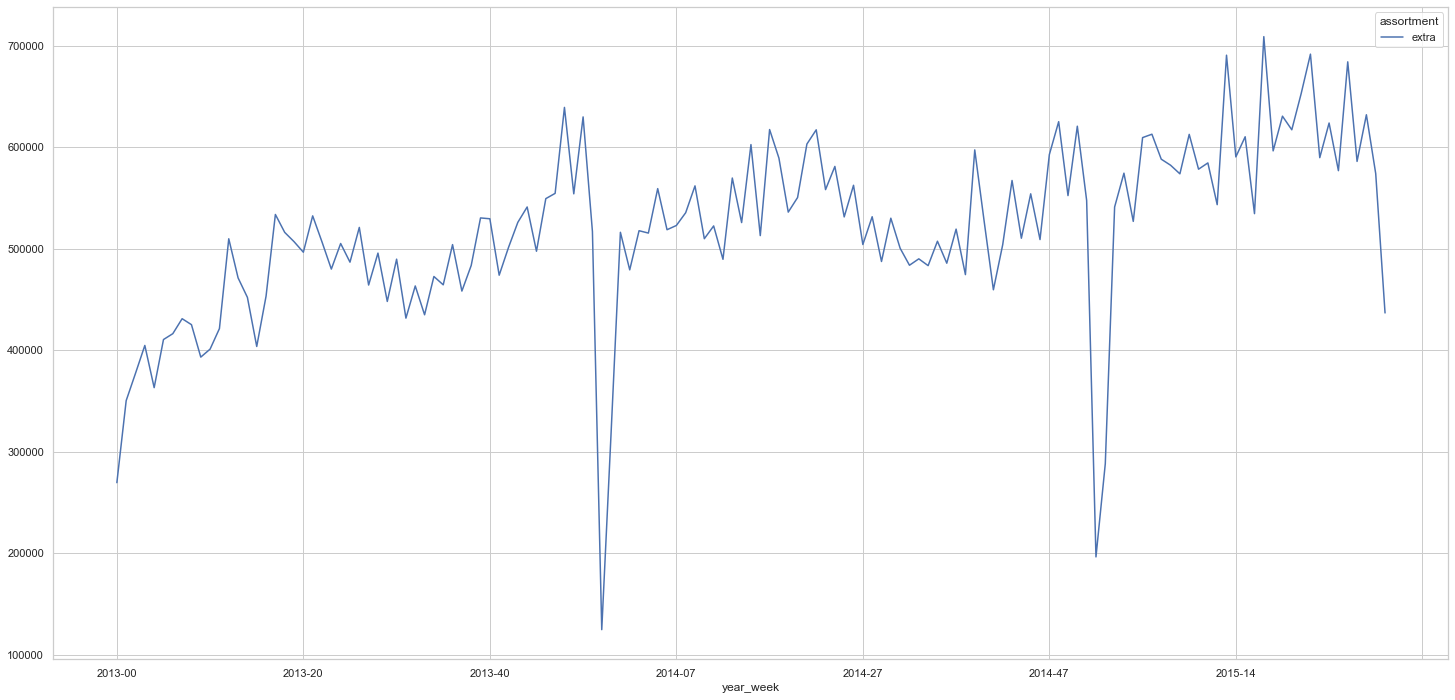

In [37]:
aux1 = df4[['assortment','sales']].groupby('assortment').sum().reset_index()
sns.barplot(x='assortment', y='sales', data=aux1);

aux2 = df4[['year_week', 'assortment','sales']].groupby(['year_week', 'assortment']).sum().reset_index()
aux2.pivot(index='year_week', columns='assortment', values='sales').plot()

aux3 = aux2[aux2['assortment'] == 'extra']
aux3.pivot(index='year_week', columns='assortment', values='sales').plot()

### **H2.** Stores with closer competitors should sell less.
**False** Stores with CLOSER competitors sell MORE. -------> Can generate an Insight

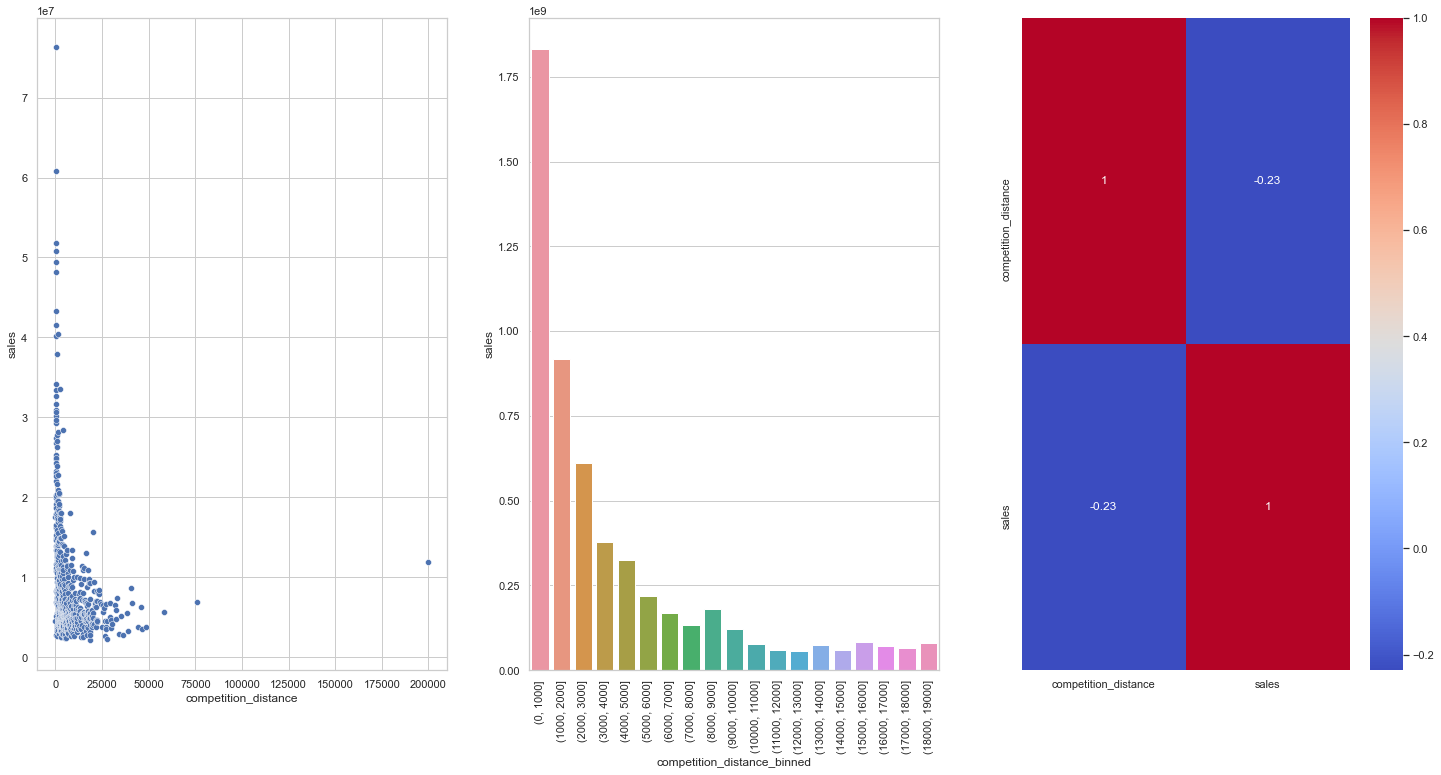

In [38]:
aux1 = df4[['competition_distance', 'sales']].groupby('competition_distance').sum().reset_index()

plt.subplot(1,3,1)
sns.scatterplot(x='competition_distance', y='sales', data=aux1);

plt.subplot(1,3,2)
bins = list(np.arange(0, 20000, 1000))
aux1['competition_distance_binned'] = pd.cut(aux1['competition_distance'], bins=bins)
aux2 = aux1[['competition_distance_binned', 'sales']].groupby('competition_distance_binned').sum().reset_index()
sns.barplot(x='competition_distance_binned', y='sales', data=aux2);
plt.xticks(rotation=90)

plt.subplot(1,3,3)
sns.heatmap(aux1.corr(method='pearson'), annot=True, cmap='coolwarm');

### **H3.** Stores with competitors for a longer period of time should sell more.
**False** Stores with competitors for a LONGER period of time SELL LESS. -------> Can generate an Insight

<AxesSubplot:>

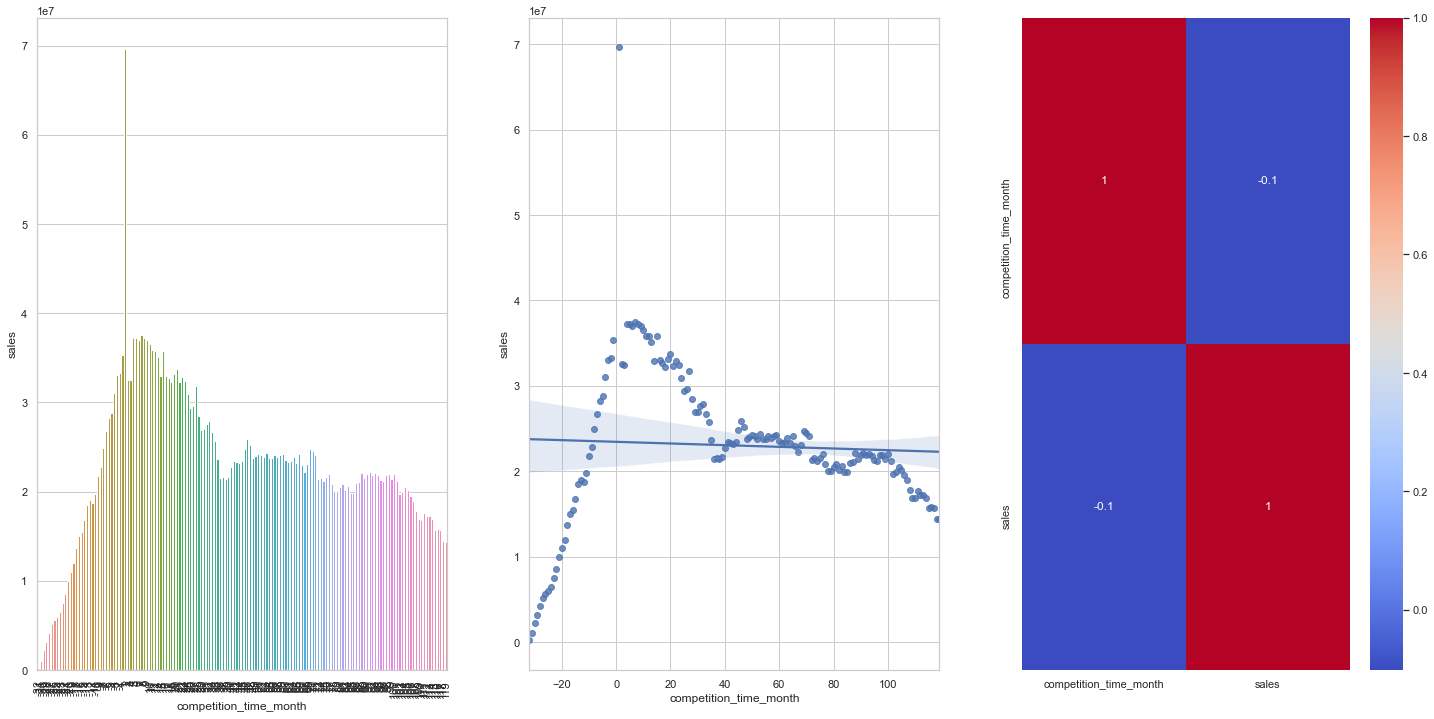

In [39]:
plt.subplot(1,3,1)
aux1 = df4[['competition_time_month', 'sales']].groupby('competition_time_month').sum().reset_index()
aux2 = aux1[(aux1['competition_time_month'] < 120) & (aux1['competition_time_month'] != 0)]
sns.barplot(x='competition_time_month', y='sales', data=aux2,);
plt.xticks(rotation=90);

plt.subplot(1,3,2)
sns.regplot(x='competition_time_month', y='sales', data=aux2);

plt.subplot(1,3,3)
sns.heatmap(aux1.corr(method='pearson'), annot=True, cmap='coolwarm')

### **H4.** Stores with active promotions for a longer time should sell more.
**False** Stores with ACTIVE PROMOTIONS for longer SELL LESS, after a given period of time. -------> Can generate an Insight

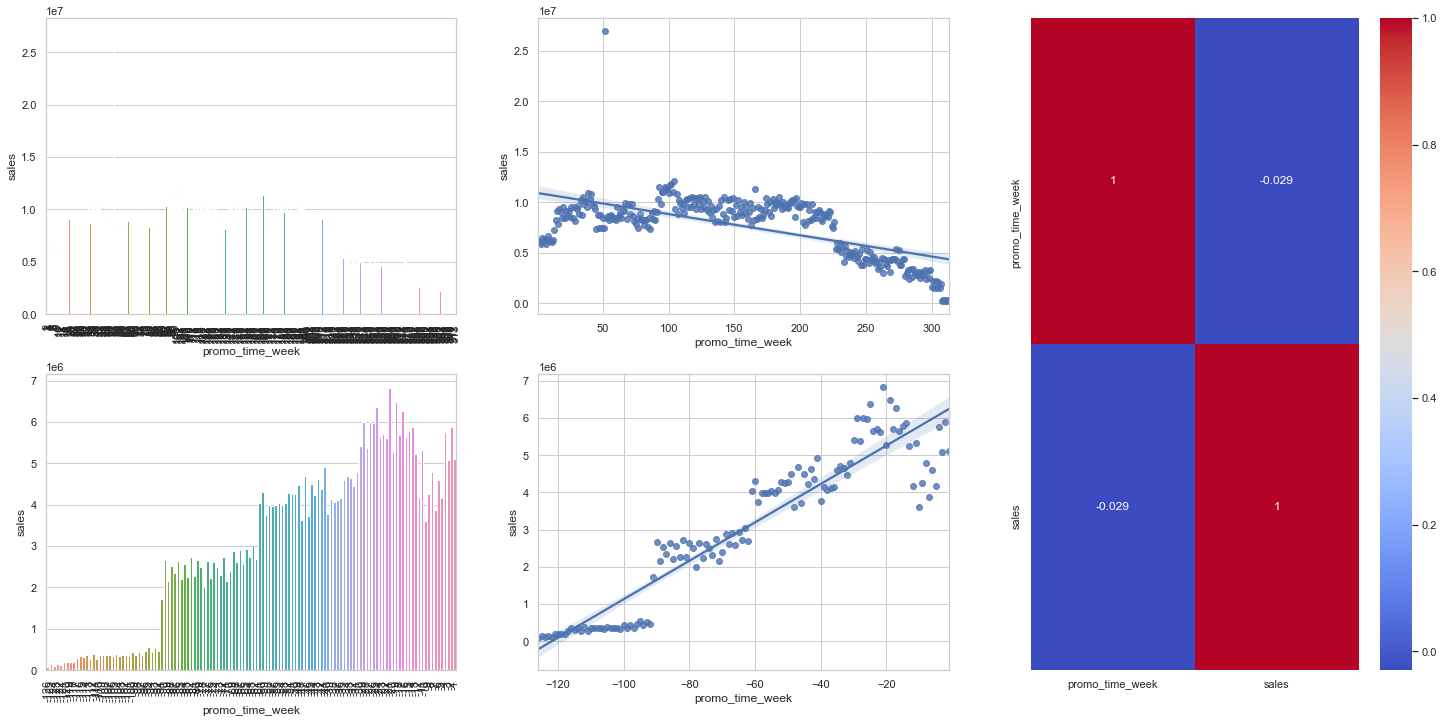

In [40]:
aux1 = df4[['promo_time_week', 'sales']].groupby('promo_time_week').sum().reset_index()

grid = GridSpec(2,3)

plt.subplot(grid[0,0])
aux2 = aux1[aux1['promo_time_week'] > 0]  # extended promo
sns.barplot(x='promo_time_week', y='sales', data=aux2);
plt.xticks(rotation=90);

plt.subplot(grid[0,1])
sns.regplot(x='promo_time_week', y='sales', data=aux2);

plt.subplot(grid[1,0])
aux3 = aux1[aux1['promo_time_week'] < 0]  # regular promo
sns.barplot(x='promo_time_week', y='sales', data=aux3);
plt.xticks(rotation=90);

plt.subplot(grid[1,1])
sns.regplot(x='promo_time_week', y='sales', data=aux3);

plt.subplot(grid[:,2])
sns.heatmap(aux1.corr(method='pearson'), annot=True, cmap='coolwarm');


### <s>**H5.** Stores with more promotion days should sell more.</s>

### **H6.** Stores with more consecutive promotions should sell more.
**False** Stores with MORE consecutive promotions SELL LESS. -------> Can generate an Insight

In [41]:
df4[['promo','promo2','sales']].groupby(['promo','promo2']).sum().reset_index()

,promo,promo2,sales
0,0,0,1482612096
1,0,1,1289362241
2,1,0,1628930532
3,1,1,1472275754


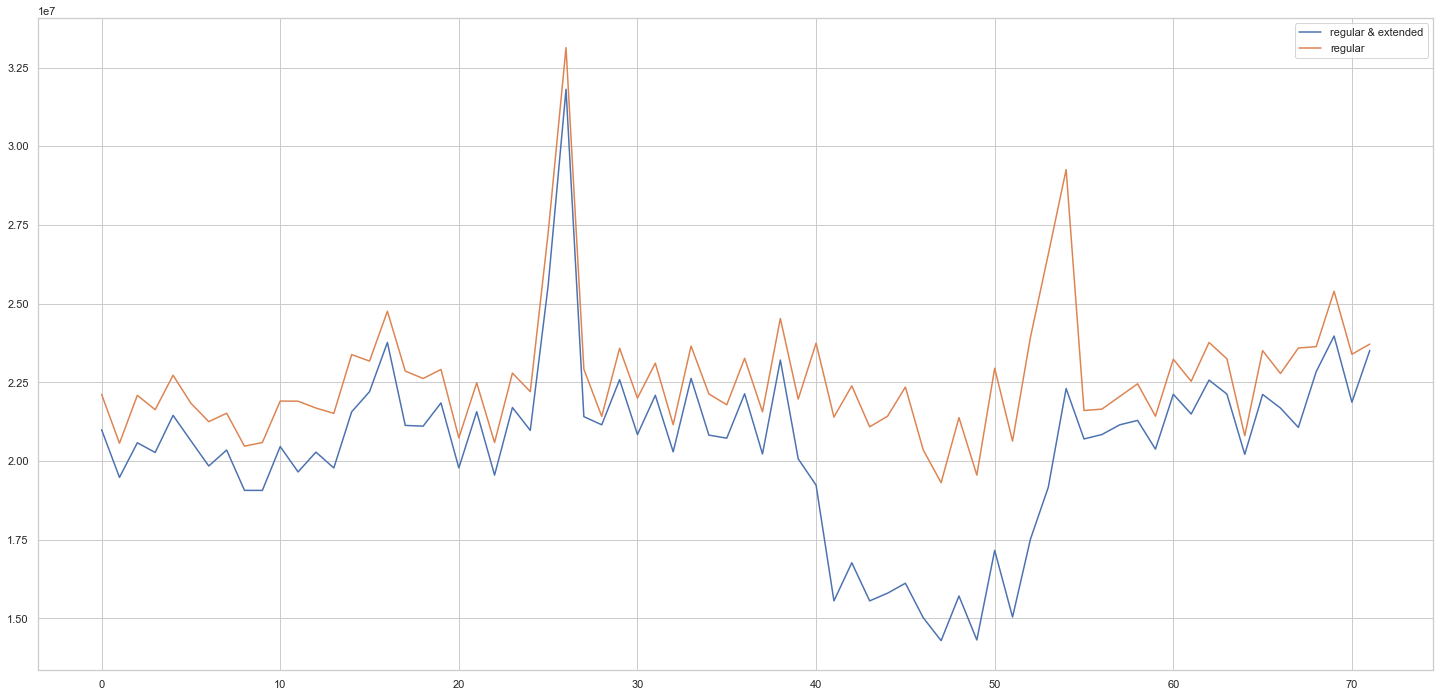

In [42]:
aux1 = df4[(df4['promo'] == 1) & (df4['promo2'] == 1)][['year_week', 'sales']].groupby('year_week').sum().reset_index()
ax = aux1.plot()

aux2 = df4[(df4['promo'] == 1) & (df4['promo2'] == 0)][['year_week', 'sales']].groupby('year_week').sum().reset_index()
aux2.plot(ax=ax)

ax.legend(labels=['regular & extended','regular'])

### **H7.** Stores open during Christmas should sell more.
**False** Stores open in the christmas day SELL LESS -------> Probably not an Insight

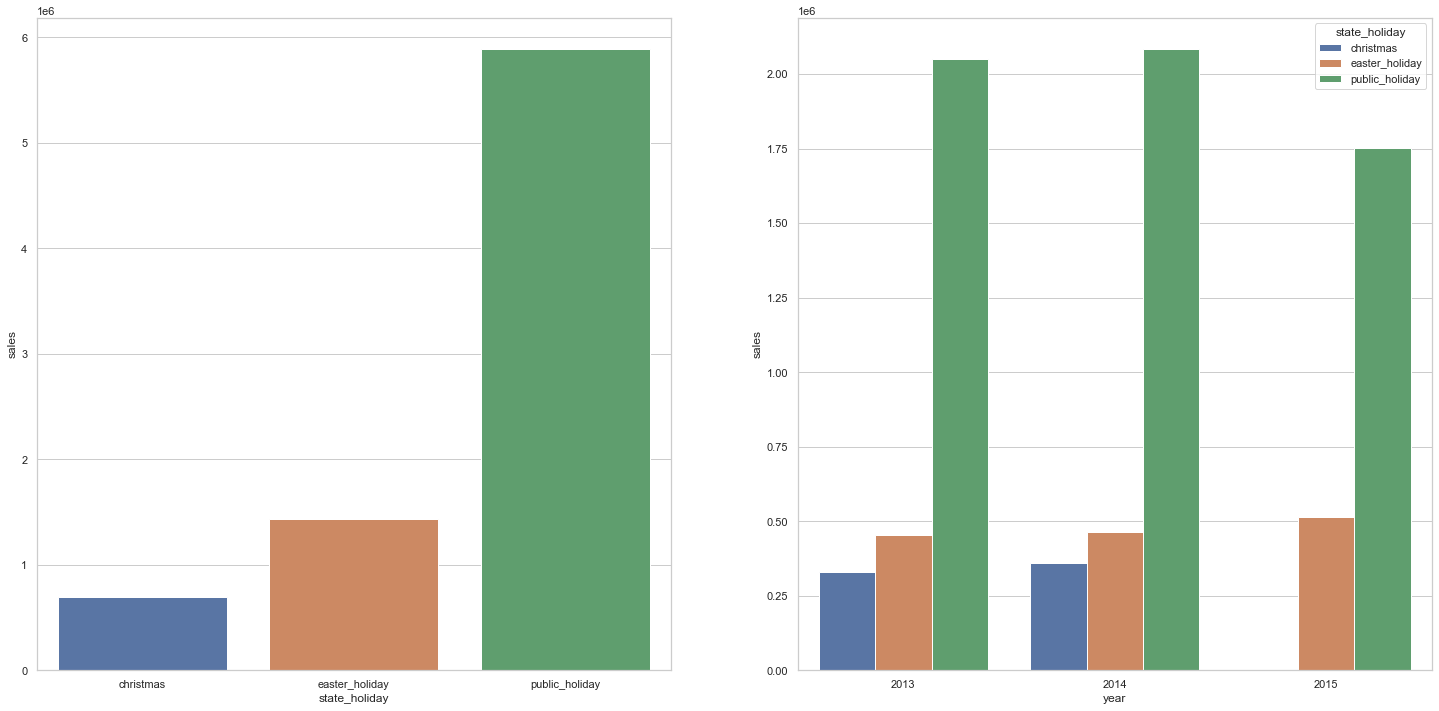

In [43]:
aux = df4[df4['state_holiday'] != 'regular_day']

plt.subplot(1,2,1)
aux1 = aux[['state_holiday','sales']].groupby('state_holiday').sum().reset_index()
sns.barplot(x='state_holiday', y='sales', data=aux1);

plt.subplot(1,2,2)
aux2 = aux[['year','state_holiday', 'sales']].groupby(['year','state_holiday']).sum().reset_index()
sns.barplot(x='year', y='sales', hue='state_holiday', data=aux2);

### **H8.** Stores should sell more along the years.
**False** Stores SELL LESS along the years. -------> Probably not an Insight

<AxesSubplot:>

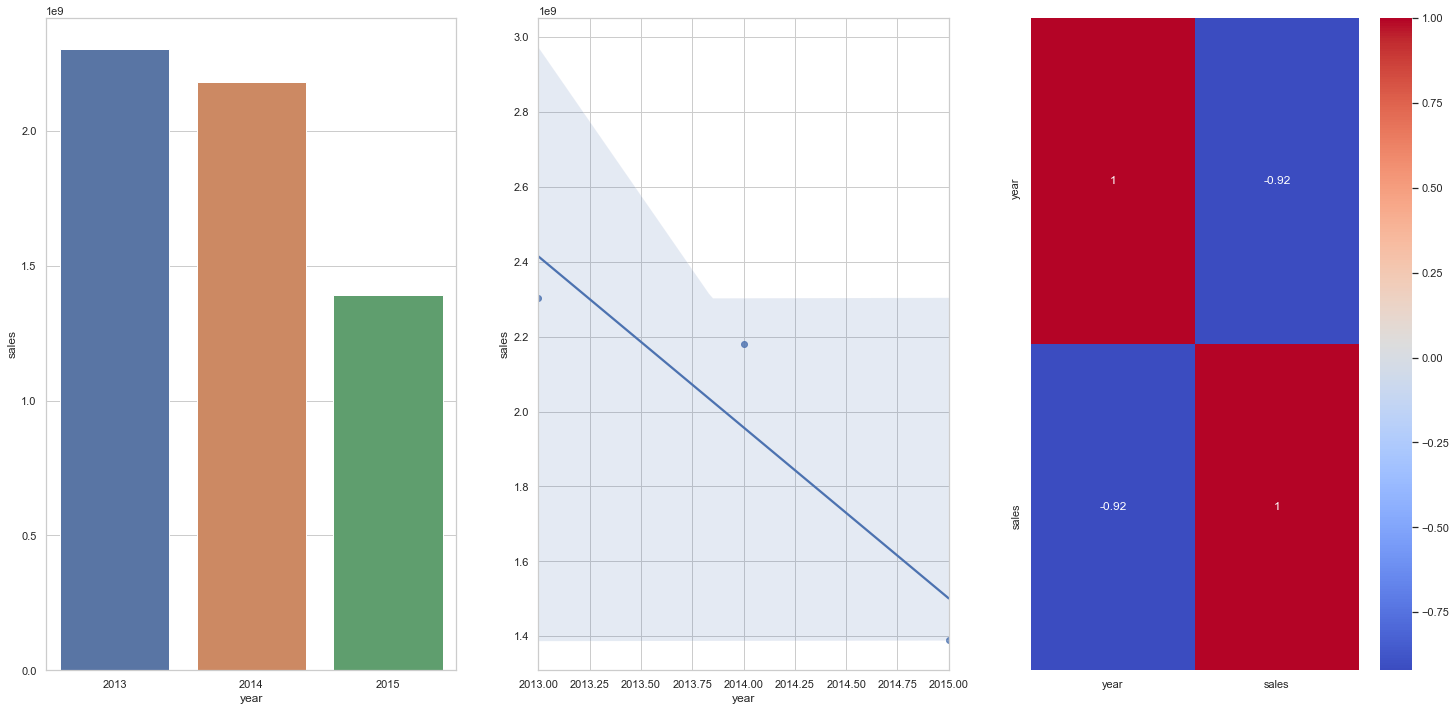

In [44]:
aux1 = df4[['year', 'sales']].groupby(['year']).sum().reset_index()

plt.subplot(1,3,1)
sns.barplot(x='year', y='sales', data=aux1);

plt.subplot(1,3,2)
sns.regplot(x='year', y='sales', data=aux1);

plt.subplot(1,3,3)
sns.heatmap(aux1.corr(method='pearson'), annot=True, cmap='coolwarm')

### **H9.** Stores should sell more in the second semester of the year.
**False** Stores SELL LESS in the second semester of the year. -------> Probably not an Insight

<AxesSubplot:>

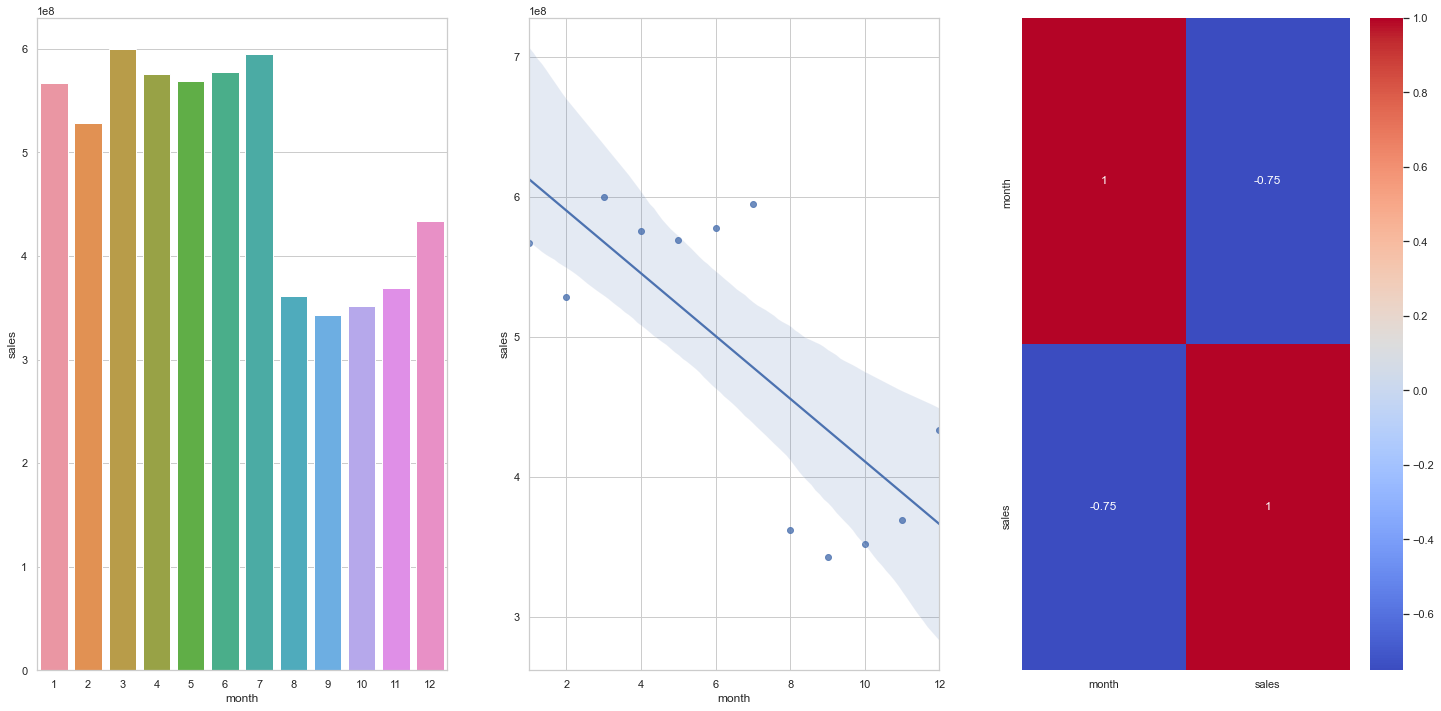

In [45]:
aux1 = df4[['month', 'sales']].groupby(['month']).sum().reset_index()

plt.subplot(1,3,1)
sns.barplot(x='month', y='sales', data=aux1);

plt.subplot(1,3,2)
sns.regplot(x='month', y='sales', data=aux1);

plt.subplot(1,3,3)
sns.heatmap(aux1.corr(method='pearson'), annot=True, cmap='coolwarm')

### **H10.** Stores should sell more after the 10th day of each month.
**True** Stores SELL MORE after the 10th day of each month. -------> Probably not an Insight

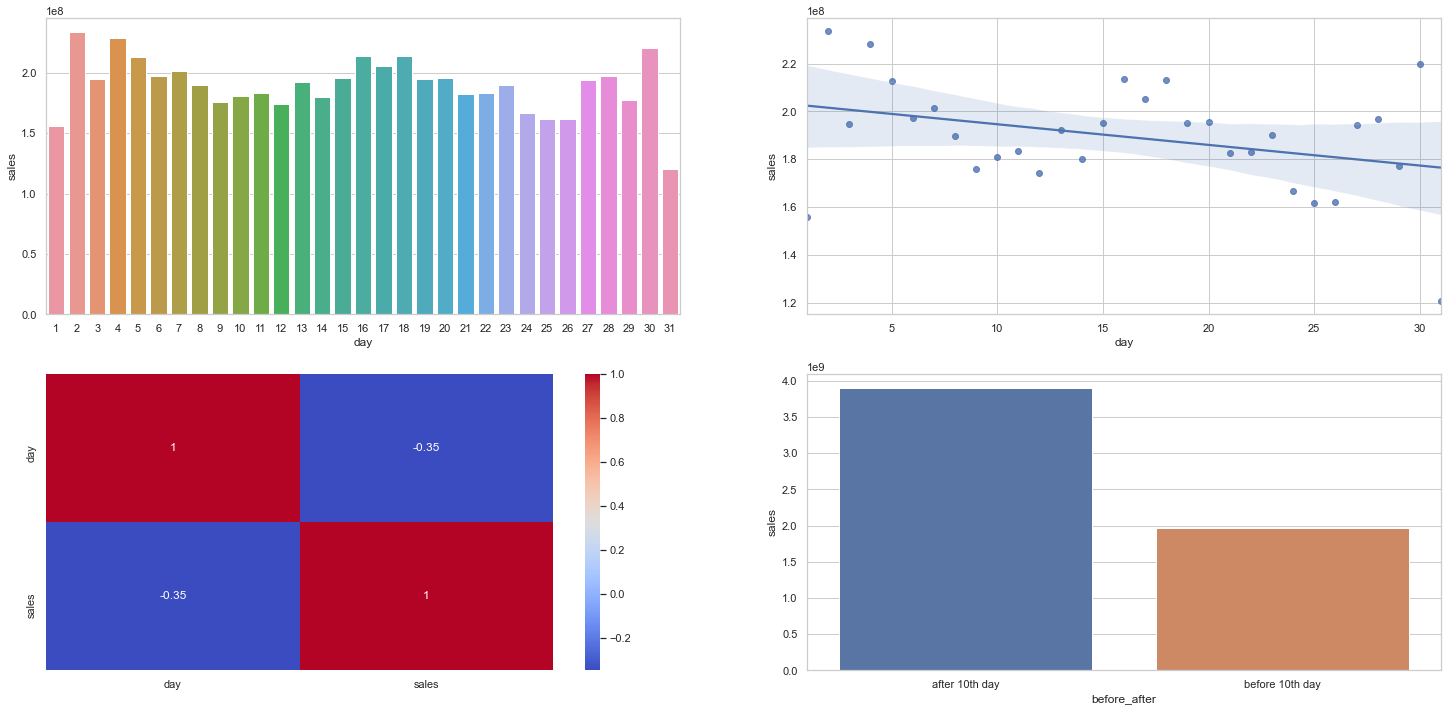

In [46]:
aux1 = df4[['day', 'sales']].groupby(['day']).sum().reset_index()

plt.subplot(2,2,1)
sns.barplot(x='day', y='sales', data=aux1);

plt.subplot(2,2,2)
sns.regplot(x='day', y='sales', data=aux1);

plt.subplot(2,2,3)
sns.heatmap(aux1.corr(method='pearson'), annot=True, cmap='coolwarm')

plt.subplot(2,2,4)
aux1['before_after'] = aux1['day'].apply(lambda x: 'before 10th day' if x <= 10 else 'after 10th day')
aux2 = aux1[['before_after', 'sales']].groupby('before_after').sum().reset_index()
sns.barplot(x='before_after', y='sales', data=aux2);


### **H11.** Stores should sell less during weekends.
**True** Stores SELL LESS on weekends. -------> Probably not an Insight

<AxesSubplot:>

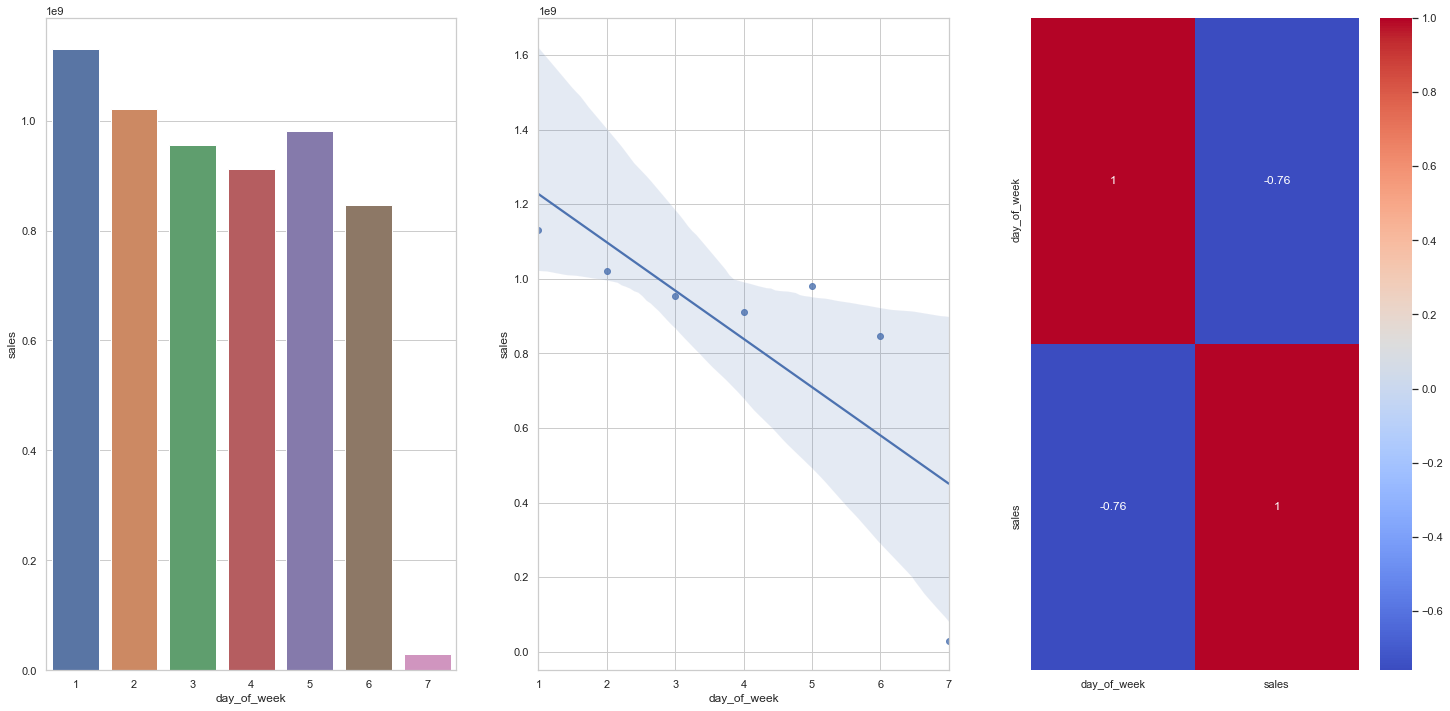

In [47]:
aux1 = df4[['day_of_week', 'sales']].groupby(['day_of_week']).sum().reset_index()

plt.subplot(1,3,1)
sns.barplot(x='day_of_week', y='sales', data=aux1);

plt.subplot(1,3,2)
sns.regplot(x='day_of_week', y='sales', data=aux1);

plt.subplot(1,3,3)
sns.heatmap(aux1.corr(method='pearson'), annot=True, cmap='coolwarm')

### **H12.** Stores should sell less during school holidays.
**True** Stores SELL LESS during school holidays (except in august). -------> Can generate an Insight

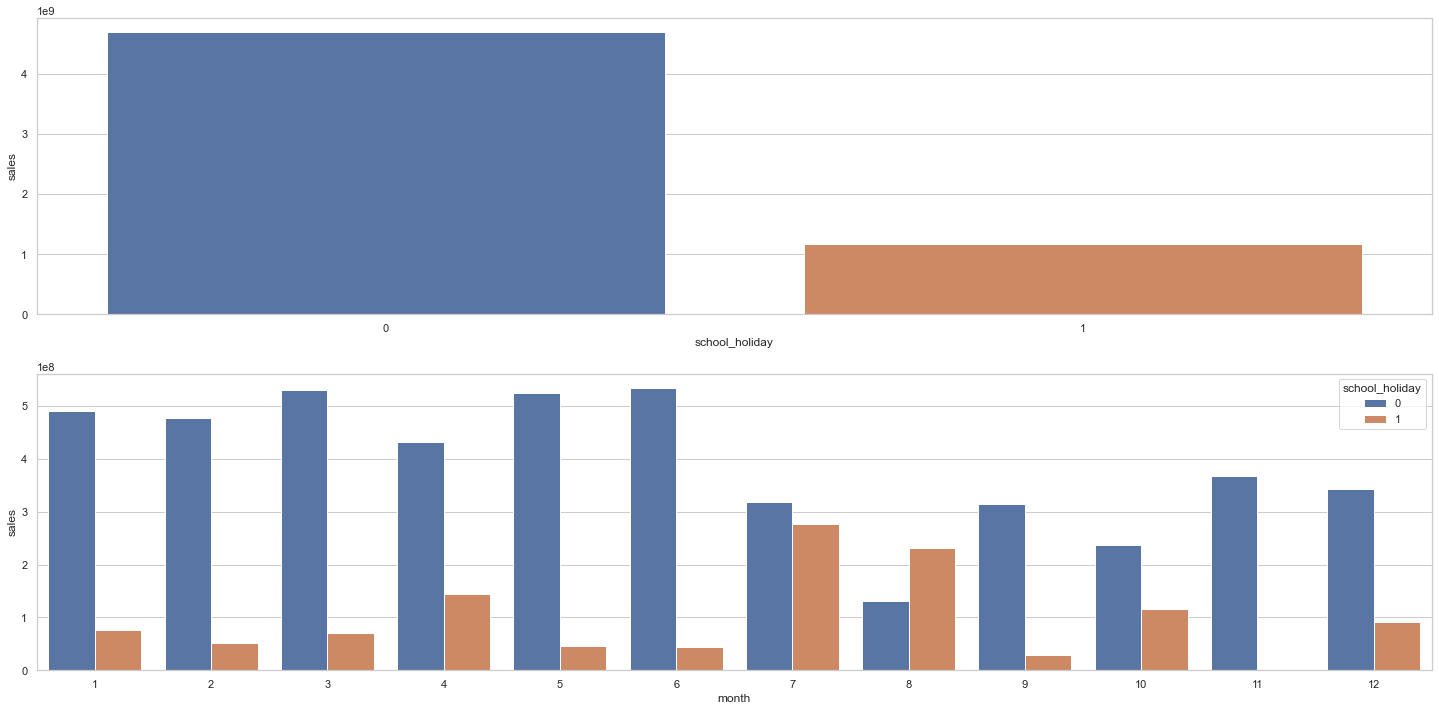

In [48]:
aux1 = df4[['school_holiday','sales']].groupby('school_holiday').sum().reset_index()

plt.subplot(2,1,1)
sns.barplot(x='school_holiday', y='sales', data=aux1);

plt.subplot(2,1,2)
aux2 = df4[['month', 'school_holiday','sales']].groupby(['school_holiday','month']).sum().reset_index()
sns.barplot(x='month', y='sales', data=aux2, hue='school_holiday');

### 4.2.1 Summary of the hypothesis

In [49]:
tab = [['Hypothesis', 'Conclusion', 'Relevance'],
       ['H1', 'False', 'Low'],
       ['H2', 'False', 'Medium'],
       ['H3', 'False', 'Medium'],
       ['H4', 'False', 'Low'],
       ['H5', '-', '-'],
       ['H6', 'False', 'Low'],
       ['H7', 'False', 'Medium'],
       ['H8', 'False', 'High'],
       ['H9', 'False', 'High'],
       ['H10', 'True', 'High'],
       ['H11', 'True', 'High'],
       ['H12', 'True', 'Low']]

print(tabulate(tab, headers='firstrow'))

Hypothesis    Conclusion    Relevance
------------  ------------  -----------
H1            False         Low
H2            False         Medium
H3            False         Medium
H4            False         Low
H5            -             -
H6            False         Low
H7            False         Medium
H8            False         High
H9            False         High
H10           True          High
H11           True          High
H12           True          Low


## 4.3. Multivariate Analysis

### 4.3.1 Numerical Attributes

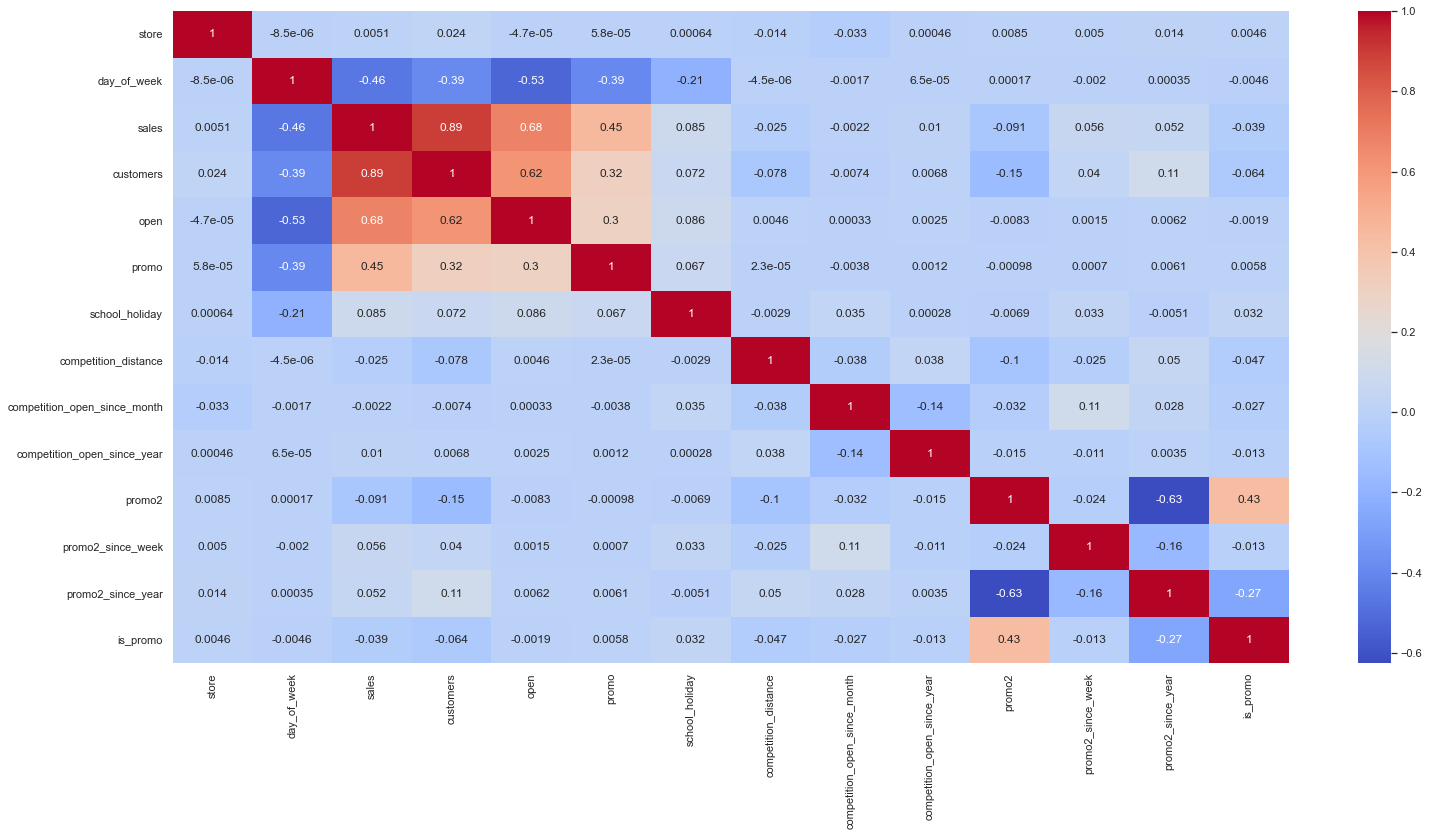

In [50]:
num_corr = num_attributes.corr(method='pearson')

sns.heatmap(num_corr, annot=True, cmap='coolwarm');

### 4.3.2 Categorical Attributes

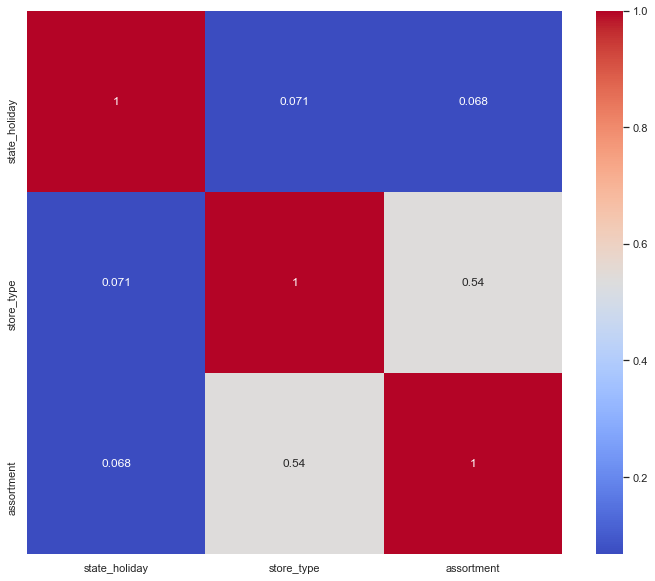

In [51]:
# Only categorical Data
a = df4.select_dtypes(include='object')

# Apply cramer_v function to correlate variables
a1 = cramer_v(a['state_holiday'], a['state_holiday'])
a2 = cramer_v(a['state_holiday'], a['store_type'])
a3 = cramer_v(a['state_holiday'], a['assortment'])

a4 = cramer_v(a['store_type'], a['state_holiday'])
a5 = cramer_v(a['store_type'], a['store_type'])
a6 = cramer_v(a['store_type'], a['assortment'])

a7 = cramer_v(a['assortment'], a['state_holiday'])
a8 = cramer_v(a['assortment'], a['store_type'])
a9 = cramer_v(a['assortment'], a['assortment'])

# correlation matrix
d = pd.DataFrame({'state_holiday': [a1, a2, a3],
              'store_type': [a4, a5, a6],
              'assortment': [a7, a8, a9]})

d = d.set_index(d.columns)

# plot
plt.figure(figsize=(12,10))
sns.heatmap(d, annot=True, cmap='coolwarm');

# 5.0. STEP 05 - DATA PREPARATION

In [52]:
df5 = df4.copy()

## 5.1. Normalization

There is no numerical variables that follow a Gaussian distribution.

## 5.2 Rescalling

In [53]:
a = df5.select_dtypes(include = ['int32', 'int64', 'float64', 'UInt32'])

In [54]:
rs = RobustScaler()
mms = MinMaxScaler()

# competition distance -> strong outlier
df5['competition_distance'] = rs.fit_transform(df5[['competition_distance']].values)

# competition time month
df5['competition_time_month'] = rs.fit_transform(df5[['competition_time_month']].values)

# promo time week
df5['promo_time_week'] = mms.fit_transform(df5[['promo_time_week']].values)

# year
df5['year'] = mms.fit_transform(df5[['year']].values)

## 5.3 Transformation

### 5.3.1 Encoding

In [55]:
# state_holiday - One hot encoding
df5 = pd.get_dummies(df5, prefix=['state_holiday'], columns=['state_holiday'])

# store_type - Label encoding
le = LabelEncoder()
df5['store_type'] = le.fit_transform(df5['store_type'])

# assortment - ordinal encoding
assortment_dict = {'basic': 1, 'extended': 2, 'extra': 3}
df5['assortment'] = df5['assortment'].map(assortment_dict)

### 5.3.2. Response Variable Transformation

In [56]:
# response variable log transformation
df5['sales'] = np.log1p(df5['sales'])

### 5.3.3. Nature Transformation

In [57]:
# day of week
df5['day_of_week_sin'] = df5['day_of_week'].apply(lambda x: np.sin(x * (2. * np.pi/7)))
df5['day_of_week_cos'] = df5['day_of_week'].apply(lambda x: np.cos(x * (2. * np.pi/7)))

# month
df5['month_sin'] = df5['month'].apply(lambda x: np.sin(x * (2. * np.pi/12)))
df5['month_cos'] = df5['month'].apply(lambda x: np.cos(x * (2. * np.pi/12)))

# day
df5['day_sin'] = df5['day'].apply(lambda x: np.sin(x * (2. * np.pi/30)))
df5['day_cos'] = df5['day'].apply(lambda x: np.cos(x * (2. * np.pi/30)))

# week of year
df5['week_of_year_sin'] = df5['week_of_year'].apply(lambda x: np.sin(x * (2. * np.pi/52)))
df5['week_of_year_cos'] = df5['week_of_year'].apply(lambda x: np.cos(x * (2. * np.pi/52)))


# 6.0. STEP 06 - FEATURE SELECTION

In [58]:
df6 = df5.copy()

## 6.1. Split Dataset into training and test data

In [59]:
df6.sample(5)

,store,day_of_week,date,sales,promo,school_holiday,store_type,assortment,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,is_promo,year,month,day,week_of_year,year_week,competition_since,competition_time_month,promo_since,promo_time_week,state_holiday_christmas,state_holiday_easter_holiday,state_holiday_public_holiday,state_holiday_regular_day,day_of_week_sin,day_of_week_cos,month_sin,month_cos,day_sin,day_cos,week_of_year_sin,week_of_year_cos
934021,437,6,2013-03-16,9.280985,0,0,2,2,-0.306452,3,2013,1,50,2010,0,0.0,3,16,11,2013-10,2013-03-01,-0.216216,2010-12-06,0.555809,0,0,0,1,-0.781831,0.623490,1.000000,6.123234e-17,-0.207912,-0.978148,0.970942,0.239316
969117,968,3,2013-02-13,8.667508,0,1,2,1,-0.183871,2,2013,0,7,2013,0,0.0,2,13,7,2013-06,2013-02-01,-0.216216,2013-02-11,0.287016,0,0,0,1,0.433884,-0.900969,0.866025,5.000000e-01,0.406737,-0.913545,0.748511,0.663123
346445,807,5,2014-09-05,9.178127,1,1,0,1,0.248387,4,2008,0,36,2014,0,0.5,9,5,36,2014-35,2008-04-01,0.837838,2014-09-01,0.287016,0,0,0,1,-0.974928,-0.222521,-1.000000,-1.836970e-16,0.866025,0.500000,-0.935016,-0.354605
726341,147,3,2013-09-18,8.662332,0,0,3,2,1.001613,9,2013,0,38,2013,0,0.0,9,18,38,2013-37,2013-09-01,-0.216216,2013-09-16,0.287016,0,0,0,1,0.433884,-0.900969,-1.000000,-1.836970e-16,-0.587785,-0.809017,-0.992709,-0.120537
757984,570,3,2013-08-21,8.086718,0,1,0,1,-0.346774,11,2006,0,34,2013,0,0.0,8,21,34,2013-33,2006-11-01,0.891892,2013-08-19,0.287016,0,0,0,1,0.433884,-0.900969,-0.866025,-5.000000e-01,-0.951057,-0.309017,-0.822984,-0.568065


In [60]:
cols_drop = ['week_of_year', 'day', 'month', 'day_of_week', 'promo_since', 'competition_since', 'year_week']

df6 = df6.drop(cols_drop, axis=1)

In [61]:
df6[['store', 'date']].groupby('store').max().reset_index()['date'][0] - datetime.timedelta(days=6*7)

Timestamp('2015-06-19 00:00:00')

In [62]:
# training data
X_train = df6[df6['date'] < '2015-06-19']
y_train = X_train['sales']

# test data
X_test = df6[df6['date'] >= '2015-06-19']
y_test = X_test['sales']

print('Min training date: {}'.format(X_train['date'].min()))
print('Max training date: {}'.format(X_train['date'].max()))

print('\nMin test date: {}'.format(X_test['date'].min()))
print('Max test date: {}'.format(X_test['date'].max()))

Min training date: 2013-01-01 00:00:00
Max training date: 2015-06-18 00:00:00

Min test date: 2015-06-19 00:00:00
Max test date: 2015-07-31 00:00:00


## 6.2. Boruta for feature selection

In [63]:
# # training and test data for boruta
# X_train_n = X_train.drop(['date', 'sales'], axis=1).values
# y_train_n = y_train.values.ravel()

# # define random forest regressor
# rf = RandomForestRegressor(n_jobs=-1)  # n_jobs = -1 ----> uses all cores

# # define Boruta
# boruta = BorutaPy(rf, n_estimators='auto', verbose=2, random_state=42).fit(X_train_n, y_train_n)

### 6.2.1 Best features from Boruta

In [64]:
# cols_selected = boruta.support_.tolist()

# # best features
# X_train_fs = X_train.drop(['date', 'sales'], axis=1)
# cols_selected_boruta = X_train_fs.iloc[:, cols_selected].columns

# # not selected boruta
# cols_not_selected_boruta = np.setdiff1d(X_train_fs.columns, cols_selected_boruta)

## 6.3. Manual Feature Selection

In [65]:
# manually added month_sin, week_of_year_sin
cols_selected_boruta = ['store', 
                        'promo', 
                        'store_type', 
                        'assortment', 
                        'competition_distance',
                        'competition_open_since_month', 
                        'competition_open_since_year', 
                        'promo2',
                        'promo2_since_week', 
                        'promo2_since_year', 
                        'competition_time_month',
                        'promo_time_week', 
                        'day_of_week_sin', 
                        'day_of_week_cos', 
                        'month_cos',
                        'month_sin',
                        'day_sin', 
                        'day_cos', 
                        'week_of_year_cos',
                        'week_of_year_sin']

cols_not_selected_boruta = ['is_promo', 
                            'month_sin', 
                            'school_holiday',
                            'state_holiday_christmas', 
                            'state_holiday_easter_holiday',
                            'state_holiday_public_holiday', 
                            'state_holiday_regular_day',
                            'week_of_year_sin', 
                            'year']

# columns to add
feat_to_add = ['date', 'sales']

# final features
cols_selected_boruta_full = cols_selected_boruta.copy()
cols_selected_boruta_full.extend(feat_to_add)

# 7.0. STEP 07 - MACHINE LEARNING MODELLING

In [66]:
df7 = df6.copy()

x_train = X_train[cols_selected_boruta]
x_test = X_test[cols_selected_boruta]

# time series data preparation
x_training = X_train[cols_selected_boruta_full]

## 7.1. Average Model

In [67]:
aux1 = x_test.copy()
aux1['sales'] = y_test.copy()

# prediction
aux2 = aux1[['store', 'sales']].groupby('store').mean().reset_index().rename(columns={'sales': 'predictions'})
aux1 = pd.merge(aux1, aux2, how='left', on='store')
yhat_baseline = aux1['predictions']

# performance
baseline_result = ml_error('Average Model', np.expm1(y_test), np.expm1(yhat_baseline))
baseline_result

,Model Name,MAE,MAPE,RMSE
0,Average Model,1354.800353,0.455051,1835.135542


## 7.2. Linear Regression Model

In [68]:
# model
lr = LinearRegression().fit(x_train, y_train)

# prediction
yhat_lr = lr.predict(x_test)

# performance
lr_result = ml_error('Linear Regression', np.expm1(y_test), np.expm1(yhat_lr))
lr_result

,Model Name,MAE,MAPE,RMSE
0,Linear Regression,1861.127229,0.291652,2662.291292


### 7.2.1. Linear Regression Model - Cross Validation

In [69]:
lr_result_cv = cross_val(x_training, 5, 'Linear Regression', lr, verbose=False)
lr_result_cv

,Model Name,MAE CV,MAPE CV,RMSE CV
0,Linear Regression,2077.72 +/- 295.95,0.3 +/- 0.02,2945.54 +/- 469.14


## 7.3. Regularized Linear Regression Model

In [70]:
# model
lrr = Lasso(alpha=0.01).fit(x_train, y_train)  # reducing alpha, the model presents better results

# prediction
yhat_lrr = lrr.predict(x_test)

# performance
lrr_result = ml_error('Linear Regression - Lasso', np.expm1(y_test), np.expm1(yhat_lrr))
lrr_result

,Model Name,MAE,MAPE,RMSE
0,Linear Regression - Lasso,1891.398669,0.289252,2743.459417


### 7.3.1. Regularized Linear Regression Model - Cross Validation

In [71]:
lrr_result_cv = cross_val(x_training, 5, 'Linear Regression - Lasso', lrr, verbose=False)
lrr_result_cv

,Model Name,MAE CV,MAPE CV,RMSE CV
0,Linear Regression - Lasso,2117.99 +/- 342.74,0.29 +/- 0.01,3058.17 +/- 506.07


## 7.4. Random Forest Regressor

In [72]:
# model
rf = RandomForestRegressor(n_estimators=100, n_jobs=-1, random_state=42).fit(x_train, y_train)  # reducing alpha, the model presents better results

# prediction
yhat_rf = rf.predict(x_test)

# performance
rf_result = ml_error('Random Forest Regressor', np.expm1(y_test), np.expm1(yhat_rf))
rf_result

,Model Name,MAE,MAPE,RMSE
0,Random Forest Regressor,678.900404,0.099816,1011.382921


### 7.4.1. Random Forest Regressor - Cross Validation

In [73]:
rf_result_cv = cross_val(x_training, 5, 'Random Forest Regressor', rf, verbose=True)
rf_result_cv


KFold Number: 5

KFold Number: 4

KFold Number: 3

KFold Number: 2

KFold Number: 1


,Model Name,MAE CV,MAPE CV,RMSE CV
0,Random Forest Regressor,838.51 +/- 219.95,0.12 +/- 0.02,1257.95 +/- 320.68


## 7.5. XGBoost Regressor

In [74]:
# model
model_xgb = xgb.XGBRegressor(objective = 'reg:squarederror',
                             n_estimators = 100, 
                             eta = 0.01,
                             max_depth = 10,
                             subsample = 0.7,
                             colsample_bytree = 0.9).fit(x_train, y_train)  # reducing alpha, the model presents better results

# prediction
yhat_xgb = model_xgb.predict(x_test)

# performance
xgb_result = ml_error('XGBoost Regressor', np.expm1(y_test), np.expm1(yhat_xgb))
xgb_result

C:\Users\debor\anaconda3\envs\DScourseEnv\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


,Model Name,MAE,MAPE,RMSE
0,XGBoost Regressor,6683.519691,0.94945,7330.807064


### 7.5.1. XGBoost Regressor - Cross Validation

In [75]:
xgb_result_cv = cross_val(x_training, 5, 'XGBoost Regressor', model_xgb, verbose=True)
xgb_result_cv


KFold Number: 5


C:\Users\debor\anaconda3\envs\DScourseEnv\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(



KFold Number: 4


C:\Users\debor\anaconda3\envs\DScourseEnv\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(



KFold Number: 3


C:\Users\debor\anaconda3\envs\DScourseEnv\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(



KFold Number: 2


C:\Users\debor\anaconda3\envs\DScourseEnv\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(



KFold Number: 1


C:\Users\debor\anaconda3\envs\DScourseEnv\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


,Model Name,MAE CV,MAPE CV,RMSE CV
0,XGBoost Regressor,7049.15 +/- 588.64,0.95 +/- 0.0,7715.15 +/- 689.49


## 7.6. Comparing Model's Performance

### 7.6.1. Single Performance

In [76]:
models_performance = pd.concat([baseline_result, lr_result, lrr_result, rf_result, xgb_result])
models_performance.sort_values('RMSE')

,Model Name,MAE,MAPE,RMSE
0,Random Forest Regressor,678.900404,0.099816,1011.382921
0,Average Model,1354.800353,0.455051,1835.135542
0,Linear Regression,1861.127229,0.291652,2662.291292
0,Linear Regression - Lasso,1891.398669,0.289252,2743.459417
0,XGBoost Regressor,6683.519691,0.949450,7330.807064


### 7.6.2. Real Performance - Cross Validation

In [79]:
models_performance_cv = pd.concat([lr_result_cv, lrr_result_cv, rf_result_cv, xgb_result_cv])
models_performance_cv.sort_values('RMSE CV')

,Model Name,MAE CV,MAPE CV,RMSE CV
0,Random Forest Regressor,838.51 +/- 219.95,0.12 +/- 0.02,1257.95 +/- 320.68
0,Linear Regression,2077.72 +/- 295.95,0.3 +/- 0.02,2945.54 +/- 469.14
0,Linear Regression - Lasso,2117.99 +/- 342.74,0.29 +/- 0.01,3058.17 +/- 506.07
0,XGBoost Regressor,7049.15 +/- 588.64,0.95 +/- 0.0,7715.15 +/- 689.49
